# Final project -- milestone 4

Contributor: Martin Jin, Qimei Lin, Yingxue Lu, Yuhan Zhang

Due Date: 12/11/2019

In [1]:
# import the necessary libraries
import pandas as pd
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
# ! pip install pandas-datareader
import pandas_datareader.data as web
import datetime
from sklearn.linear_model import LinearRegression
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsRegressor
sns.set(style="whitegrid")

## Import and Process Tweet data

1. Import Dataset from 'data/trump-tweets-11-18-2019.csv'

2. Change the data type of created_at to datetime.date

3. Restrict the dataset to original tweet only

4. Group by created_at to aggregate all tweets in a day to a single datum point.

5. Sort the Tweet data with a descending date order 

In [2]:
df_tweets = pd.read_csv('data/trump-tweets-11-18-2019.csv')
df_tweets.head()

source                                               text           created_at  retweet_count  favorite_count is_retweet               id_str
0  Twitter for iPhone                            https://t.co/Mqj5tXaDAz  11-18-2019 04:38:28          15115           41938      False  1196286528546332672
1  Twitter for iPhone  “All they do is bring up witnesses who didn’t ...  11-18-2019 03:39:38          16476           61998      False  1196271720392511489
2  Twitter for iPhone  “The Impeachment started before he even became...  11-18-2019 02:40:04          18488           75282      False  1196256729471827968
3  Twitter for iPhone                            https://t.co/1Rg66Tn4uP  11-17-2019 22:57:43          16318           51690      False  1196200775560634368
4  Twitter for iPhone                            https://t.co/D66PEkuX6d  11-17-2019 22:51:37          12209           38663      False  1196199239715639302

In [3]:
#get the tweet data from downloaded data
df_tweets['created_at'] = pd.to_datetime(df_tweets['created_at']).dt.date
df_tweets['trump_tweet_cnt'] =[1 if reFlag ==False else 0 for reFlag in df_tweets['is_retweet'].values]
df_tweets['trump_retweet_cnt'] =[0 if  reFlag ==False else 1 for reFlag in df_tweets['is_retweet'].values]
df_tweets_cleaned = df_tweets.groupby('created_at', as_index = False).agg({
    'trump_tweet_cnt': 'sum',
    'trump_retweet_cnt': 'sum',
    'retweet_count': 'sum',
    'favorite_count': 'sum',
    'text':'sum'
})

df_tweets_cleaned= df_tweets_cleaned.sort_values('created_at',ascending=False)
df_tweets_cleaned.head()

created_at  trump_tweet_cnt  trump_retweet_cnt  retweet_count  favorite_count                                               text
1018  2019-11-18                3                  0          50079          179218  https://t.co/Mqj5tXaDAz“All they do is bring u...
1017  2019-11-17               36                 15         666343         1668991  https://t.co/1Rg66Tn4uPhttps://t.co/D66PEkuX6d...
1016  2019-11-16               14                 11         414895          932464  Louisiana 3 hours left get out and Vote for @E...
1015  2019-11-15               19                 24         733886         1313131  https://t.co/8h6ZmdGlPf https://t.co/shaijXMXl...
1014  2019-11-14               13                 21         444871          988437  ....We send our deepest condolences to the fam...

### Import lexicon polarity data. The polarity file was adopted from vader Sentiment: https://github.com/cjhutto/vaderSentiment.git

In [4]:
sent = pd.read_csv('data/vader_lexicon.txt', sep='\t', header=None)
sent = sent.drop([2, 3], 1)
sent.index.rename('token', inplace=True)
sent.rename(columns={1: 'polarity'}, inplace=True)
sent.head()

0  polarity
token               
0       $:      -1.5
1       %)      -0.4
2      %-)      -1.5
3      &-:      -0.4
4       &:      -0.7

### The following section puts polarity and tag information into Trump's sweet data set

In [5]:
trump_tweets = pd.read_csv('data/trump-tweet-in-office.csv')
trump_tweets['created_at'] =  pd.to_datetime(trump_tweets['created_at']).dt.date

trump = trump_tweets.copy()
trump['id']=trump['id_str']
trump = trump.set_index(['id'])

repl_punc = trump['text'].str.replace(r"[?|,|$|!|&|.|#|^|;|:|/|\"]", ' ')
replacequotes = repl_punc.str.replace(r'^"', '')

# Save your regex in punct_re
punct_re = r"[^\w\s]"
#[?|,|$|!|&|.|#|^|;|:|/|\"]
trump['no_punc'] = trump['text'].str.replace(punct_re, " ")

In [6]:
trumpcopy = trump.copy()
changed_punc = trumpcopy['no_punc'].str.replace('\s+', ' ')
trumpcopy['no_punc'] = changed_punc
splt = trumpcopy['no_punc'].str.split(expand=True).stack().reset_index().set_index('id')
splt.columns = ['num', 'word']

In [7]:
splt.head(10)


num          word
id                                    
1187551862616141824    0            RT
1187551862616141824    1  RepLeeZeldin
1187551862616141824    2          This
1187551862616141824    3   impeachment
1187551862616141824    4       inquiry
1187551862616141824    5           has
1187551862616141824    6      produced
1187551862616141824    7       NOTHING
1187551862616141824    8            to
1187551862616141824    9       impeach

In [8]:
tidy_format = splt
newt = tidy_format.reset_index()
newsent = sent.reset_index().rename(columns = {'token': 'word'})
display(newt.head())
display(newsent.head())

id  num          word
0  1187551862616141824    0            RT
1  1187551862616141824    1  RepLeeZeldin
2  1187551862616141824    2          This
3  1187551862616141824    3   impeachment
4  1187551862616141824    4       inquiry

word    0  polarity
0     0   $:      -1.5
1     1   %)      -0.4
2     2  %-)      -1.5
3     3  &-:      -0.4
4     4   &:      -0.7

In [9]:
newt = tidy_format.reset_index()
#newt = newt.drop('num')
newt1 = newt[['id', 'word']].copy()
newsent = sent.reset_index().rename(columns = {0: 'word'})
newsent1 =newsent[['polarity', 'word']].copy()
display(newt1.head())
display(newsent1.head(10))

id          word
0  1187551862616141824            RT
1  1187551862616141824  RepLeeZeldin
2  1187551862616141824          This
3  1187551862616141824   impeachment
4  1187551862616141824       inquiry

polarity      word
0      -1.5        $:
1      -0.4        %)
2      -1.5       %-)
3      -0.4       &-:
4      -0.7        &:
5       1.6  ( '}{' )
6      -0.9        (%
7       2.2      ('-:
8       2.3       (':
9       2.1      ((-:

In [10]:
polar = pd.merge(newt1, newsent1, how='outer', on= 'word')
newpol = polar.groupby('id').sum()
###newpol = newpol.drop('num', 1).fillna(0)
newpol = newpol.fillna(0)

In [11]:
polarities = newpol
maybpol = polarities.reset_index()
maybtrump = trump.reset_index()

In [12]:
display(maybpol.head())
display(maybtrump.head())

id  polarity
0  8.222424e+17       1.7
1  8.222987e+17       2.7
2  8.224214e+17      -1.0
3  8.225018e+17       1.7
4  8.225019e+17       1.4

id              source                                               text  created_at  retweet_count  favorite_count is_retweet               id_str                                            no_punc
0  1187551862616141824  Twitter for iPhone  RT @RepLeeZeldin: This impeachment inquiry has...  2019-10-25           8819               0       True  1187551862616141824  RT  RepLeeZeldin  This impeachment inquiry has...
1  1187551461808492544  Twitter for iPhone  RT @RepDougCollins: Democrats have no concern ...  2019-10-25          13713               0       True  1187551461808492544  RT  RepDougCollins  Democrats have no concern ...
2  1187551451775750144  Twitter for iPhone  RT @RepGosar: The only reason Adam Schiff is c...  2019-10-25          10961               0       True  1187551451775750144  RT  RepGosar  The only reason Adam Schiff is c...
3  1187551305281212416  Twitter for iPhone  RT @RepArrington: Let's call this sham what it...  2019-10-25           4547               0       True  1187551305281212416  RT  RepArrington  Let s call this sham what it...
4  1187551256371515392  Twitter for iPhone  RT @RepMattGaetz: Democrats are trying to use ...  2019-10-25          10491               0       True  1187551256371515392  RT  RepMattGaetz  Democrats are trying to use ...

In [13]:
senti = pd.merge(maybpol, maybtrump, how='outer', on='id').set_index('id')
new_senti= senti.loc[senti['favorite_count']>=0].drop('id_str',axis=1)
print(len(maybtrump),len(new_senti))
display(new_senti.head())

11568 11568


polarity              source                                               text  created_at  retweet_count  favorite_count is_retweet                                            no_punc
id                                                                                                                                                                                                    
8.225021e+17       3.7  Twitter for iPhone  What truly matters is not which party controls...  2017-01-20        42790.0        180394.0      False  What truly matters is not which party controls...
8.225026e+17       3.9  Twitter for iPhone  We will bring back our jobs. We will bring bac...  2017-01-20        37458.0        173821.0      False  We will bring back our jobs  We will bring bac...
8.225029e+17       0.0  Twitter for iPhone  We will follow two simple rules: BUY AMERICAN ...  2017-01-20        38092.0        161358.0      False  We will follow two simple rules  BUY AMERICAN ...
8.225041e+17       0.0  Twitter for iPhone  So to all Americans in every city near and far...  2017-01-20        14039.0         86467.0      False  So to all Americans in every city near and far...
8.226691e+17       2.7  Twitter for iPhone  THANK YOU for another wonderful evening in Was...  2017-01-21        52468.0        289942.0      False  THANK YOU for another wonderful evening in Was...

### The following section focuses on adding keyword tags to the dataset

In [14]:
keytags_politics_partisans =['crooked hilary|joe biden|obama administration|CORRUPTION','mexican wall','immigration|election medling|gun control','Nancy Pelsi','dem\W','dem party','impeach|impeachment','Russia','Putin'
                             ,'fake news']
keytags_foreign_policys =['ceasefire zones|USA soldiers|ISIS[\W]|Endless Wars','Nato\W','Middle East','Israel','Saudi\W','iran\W','iraq\W','middel east','missle'
                          ,'japan\W','korean','Mexican[\w\W]+Wall','Syria','Rocket Man','Turkey|Turks[\W|Syria|Kurdish|Kurd[\W]','china\W']
keytags_trade_war =['tpp','currency manipulate|currency manipulation','wto','unfair[\w\W]+trade'
                    ,'trade deficits|trade deficit','trade deal|trade deals','china[\w\W]+trade','trade','china','tariff'
                    ,'american[\w\W]+manufac','american first','free fair|SMART TRADE']
keytags_trade_war_senti =['worst trade deal|STUPID TRADE','currency manipulate|currency manipulation','china[\w\W]+tariff','new tariff|increase tariff','unfair[\w\W]+trade','taken advantage|taking advantage|ripped off']



trade_tags_all = []
sentiments_tags_all = []
trade_tags_score = []
foreign_policys=[]
politics_partisans=[]

foreign_tags_score_set = []
politics_tags_score_set = []

df_tweets = new_senti.copy()
counter =0

#do my own trade key tag point calculation
# regular trade key tag +1
# senti key tag +3

for i in range(len(df_tweets)) :
    #print(i)
    tagscore =0 
    politics_tag_score = 0
    foreign_tag_score = 0
    senti_tag =[]
    trade_tag =[]
    fp_tag =[]
    pp_tag =[]

    tweet_text = df_tweets.iloc[i,2]
    
    #trade tag, plus 2
    counter = 0
    for tag in keytags_trade_war:
        trade_tag = trade_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(trade_tag)>counter:
            counter +=1
            tagscore += 2
            print('trade tag:', i, trade_tag)
    
    #centi trade tag, plus 5
    counter = 0
    for tag in keytags_trade_war_senti:
        senti_tag = senti_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(senti_tag)>counter:
            counter +=1
            tagscore += 5
            print('trade centi:', i, trade_tag)
            #print(tweet_text)
    
    #foreign policy tag, plus 1
    counter = 0
    for tag in keytags_foreign_policys:
        fp_tag = fp_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(fp_tag)>counter:
            counter +=1
            foreign_tag_score +=1
            print('foreign policy:', i, fp_tag)
    
    for tag in keytags_politics_partisans:
        pp_tag = pp_tag + re.findall(tag,tweet_text, re.IGNORECASE)
        if len(pp_tag)>counter:
            counter +=1
            politics_tag_score +=1
            print('politics :', i, pp_tag)
            
    trade_tags_score.append(tagscore)   
    
    trade_tags_all.append(trade_tag)
    sentiments_tags_all.append(senti_tag)
    foreign_policys.append(fp_tag)
    politics_partisans.append(pp_tag)
    foreign_tags_score_set.append(foreign_tag_score)
    politics_tags_score_set.append(politics_tag_score)
print(counter)

politics : 12 ['FAKE NEWS']
trade tag: 20 ['trade deficit']
trade tag: 20 ['trade deficit', 'trade']
trade tag: 24 ['trade deficits']
trade tag: 24 ['trade deficits', 'trade']
trade centi: 24 ['trade deficits', 'trade']
politics : 29 ['FAKE NEWS']
politics : 32 ['FAKE NEWS']
foreign policy: 33 ['ISIS ']
politics : 43 ['Obama Administration']
foreign policy: 45 ['Iran ']
foreign policy: 46 ['Iran ', 'Iran ']
foreign policy: 46 ['Iran ', 'Iran ']
foreign policy: 47 ['Iran ']
politics : 48 ['FAKE NEWS']
politics : 54 ['FAKE NEWS']
politics : 60 ['fake news']
foreign policy: 62 ['Iran ']
politics : 62 ['Russia', 'Putin']
politics : 70 ['FAKE NEWS']
trade tag: 74 ['China']
foreign policy: 74 ['China ']
politics : 86 ['fake news']
politics : 87 ['Russia']
politics : 88 ['Russia']
politics : 92 ['FAKE NEWS']
politics : 98 ['FAKE NEWS']
politics : 100 ['fake news']
politics : 112 ['FAKE NEWS']
politics : 127 ['Russia']
politics : 128 ['Obama Administration']
politics : 128 ['Obama Administrati

foreign policy: 926 ['Iran ']
trade tag: 937 ['trade']
politics : 946 ['Fake News']
foreign policy: 957 ['Rocket Man']
politics : 987 ['Fake News']
politics : 1013 ['Fake News']
politics : 1015 ['Fake News']
politics : 1016 ['Fake News']
politics : 1023 ['FAKE NEWS']
politics : 1024 ['Fake News']
foreign policy: 1026 ['Rocket Man']
politics : 1034 ['Fake News', 'Fake News']
politics : 1039 ['Fake News']
politics : 1041 ['Fake News']
foreign policy: 1050 ['Iran ']
foreign policy: 1054 ['Iran ']
politics : 1059 ['immigration']
politics : 1063 ['Fake News']
politics : 1065 ['Fake News']
foreign policy: 1072 ['isis ']
politics : 1079 ['Fake News']
trade tag: 1088 ['trade']
foreign policy: 1088 ['Iran ', 'Iran!']
foreign policy: 1088 ['Iran ', 'Iran!']
trade tag: 1099 ['TPP']
politics : 1106 ['Fake News']
politics : 1120 ['Russia']
foreign policy: 1123 ['ISIS ']
politics : 1124 ['Fake News']
politics : 1131 ['Fake News']
politics : 1132 ['Fake News']
foreign policy: 1133 ['ISIS ']
politics 

trade centi: 1687 ['unfair trade and bad policy with countries from around the world. We must not let our country companies and workers be taken advantage of any longer. We want free fair and SMART TRADE', 'trade', 'TRADE', 'free fair', 'SMART TRADE']
trade tag: 1696 ['trade']
trade tag: 1696 ['trade', 'tariff']
trade tag: 1697 ['trade deficits']
trade tag: 1697 ['trade deficits', 'trade']
trade tag: 1697 ['trade deficits', 'trade', 'Tariff']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit', 'Trade', 'Trade']
trade tag: 1707 ['Trade Deficits', 'Trade Deficit', 'Trade', 'Trade']
foreign policy: 1711 ['Korean']
trade tag: 1714 ['trade']
trade tag: 1714 ['trade', 'tariff']
trade tag: 1716 ['China']
foreign policy: 1716 ['China ']
trade tag: 1717 ['trade']
trade tag: 1717 ['trade', 'tariff', 'tariff']
trade tag: 1717 ['trade', 'tariff', 'tariff']
politics : 1718 ['FAKE NEWS']
trade tag

foreign policy: 2251 ['Iran ']
politics : 2262 ['IMMIGRATION']
politics : 2268 ['Russia']
foreign policy: 2275 ['NATO ', 'NATO ']
foreign policy: 2275 ['NATO ', 'NATO ']
trade centi: 2276 []
trade tag: 2282 ['Trade']
trade tag: 2282 ['Trade', 'Tariff']
foreign policy: 2282 ['NATO.']
trade tag: 2283 ['trade deal']
trade tag: 2283 ['trade deal', 'trade']
foreign policy: 2284 ['NATO ']
trade tag: 2287 ['trade deficit']
trade tag: 2287 ['trade deficit', 'trade']
foreign policy: 2287 ['NATO ']
foreign policy: 2288 ['NATO ']
trade tag: 2289 ['trade']
trade tag: 2289 ['trade', 'tariff']
politics : 2291 ['Immigration']
trade tag: 2295 ['Trade']
foreign policy: 2295 ['NATO ']
foreign policy: 2296 ['NATO ']
politics : 2296 ['Russia', 'Russia']
politics : 2301 ['Russia']
politics : 2303 ['Putin']
trade tag: 2304 ['trade deal']
trade tag: 2304 ['trade deal', 'trade']
trade centi: 2304 ['trade deal', 'trade']
politics : 2305 ['Obama Administration']
politics : 2305 ['Obama Administration', 'Russia'

politics : 2660 ['Dem!']
trade tag: 2661 ['Trade Deal']
trade tag: 2661 ['Trade Deal', 'Trade']
trade centi: 2661 ['Trade Deal', 'Trade']
politics : 2662 ['Dem!']
foreign policy: 2665 ['Iran ']
foreign policy: 2666 ['Syria']
politics : 2667 ['FAKE NEWS']
politics : 2673 ['Dem ']
politics : 2684 ['Corruption']
politics : 2684 ['Corruption', 'Fake News']
trade tag: 2708 ['China', 'China']
trade tag: 2708 ['China', 'China']
foreign policy: 2708 ['China ', 'China ']
politics : 2720 ['Russia', 'Russia']
politics : 2720 ['Russia', 'Russia']
politics : 2726 ['Russia']
politics : 2733 ['corruption']
trade tag: 2736 ['China']
trade tag: 2736 ['China', 'Tariff']
trade centi: 2736 ['China', 'Tariff']
foreign policy: 2736 ['China ']
politics : 2757 ['Fake News']
politics : 2765 ['corruption']
politics : 2765 ['corruption', 'Russia']
politics : 2766 ['Russia']
politics : 2766 ['Russia', 'Fake News']
trade tag: 2780 ['Tariff', 'Tariff']
trade tag: 2780 ['Tariff', 'Tariff']
trade tag: 2789 ['China ha

politics : 3777 ['Fake News']
politics : 3782 ['impeach']
politics : 3784 ['Fake News']
foreign policy: 3788 ['Israel', 'Israel']
foreign policy: 3788 ['Israel', 'Israel']
politics : 3800 ['Russia']
politics : 3804 ['Fake News']
politics : 3816 ['Russia']
trade tag: 3820 ['Tariff']
politics : 3837 ['Dem ']
politics : 3838 ['Russia']
politics : 3842 ['Fake News']
foreign policy: 3845 ['isis ', 'isis ']
foreign policy: 3845 ['isis ', 'isis ']
politics : 3860 ['impeach', 'impeach']
politics : 3860 ['impeach', 'impeach']
trade tag: 3871 ['Trade Deal']
trade tag: 3871 ['Trade Deal', 'Trade']
foreign policy: 3880 ['Iran ']
politics : 3899 ['Russia']
politics : 3899 ['Russia', 'Fake News']
trade tag: 3917 ['China']
foreign policy: 3917 ['China ']
politics : 3919 ['Joe Biden']
politics : 3925 ['FAKE NEWS']
foreign policy: 3938 ['ISIS ', 'ISIS ']
foreign policy: 3938 ['ISIS ', 'ISIS ']
politics : 3942 ['Russia']
foreign policy: 3943 ['Israel', 'Israel']
foreign policy: 3943 ['Israel', 'Israel']

foreign policy: 4497 ['Iran.']
foreign policy: 4498 ['Iran ']
politics : 4506 ['Immigration']
politics : 4516 ['Russia']
trade tag: 4517 ['trade']
foreign policy: 4517 ['Japan ', 'Japan ']
foreign policy: 4517 ['Japan ', 'Japan ']
politics : 4529 ['Putin', 'Putin']
politics : 4529 ['Putin', 'Putin']
politics : 4530 ['Fake News']
politics : 4539 ['Impeach', 'Impeach']
politics : 4539 ['Impeach', 'Impeach']
trade tag: 4543 ['Trade']
foreign policy: 4543 ['Japan ', 'Japan.']
foreign policy: 4543 ['Japan ', 'Japan.']
trade tag: 4544 ['Trade']
foreign policy: 4544 ['Japan ', 'Japan.']
foreign policy: 4544 ['Japan ', 'Japan.']
foreign policy: 4549 ['Japan!']
trade tag: 4551 ['trade']
politics : 4552 ['Russia']
foreign policy: 4553 ['Japan ']
politics : 4556 ['Joe Biden']
foreign policy: 4557 ['Japan:', 'Japan ', 'Japan ']
foreign policy: 4557 ['Japan:', 'Japan ', 'Japan ']
foreign policy: 4557 ['Japan:', 'Japan ', 'Japan ']
foreign policy: 4558 ['Japan!']
trade tag: 4560 ['Trade']
foreign po

politics : 5686 ['Fake News']
trade tag: 5690 ['China']
foreign policy: 5690 ['China.']
trade tag: 5691 ['unfairly on Trade']
trade tag: 5691 ['unfairly on Trade', 'China that want me to get together with the EU and others to go after China Trade practices remember the EU &amp; all treat us VERY unfairly on Trade']
trade tag: 5691 ['unfairly on Trade', 'China that want me to get together with the EU and others to go after China Trade practices remember the EU &amp; all treat us VERY unfairly on Trade', 'Trade', 'Trade']
trade tag: 5691 ['unfairly on Trade', 'China that want me to get together with the EU and others to go after China Trade practices remember the EU &amp; all treat us VERY unfairly on Trade', 'Trade', 'Trade', 'China', 'China']
trade tag: 5691 ['unfairly on Trade', 'China that want me to get together with the EU and others to go after China Trade practices remember the EU &amp; all treat us VERY unfairly on Trade', 'Trade', 'Trade', 'China', 'China']
trade tag: 5691 ['un

foreign policy: 6403 ['endless wars']
foreign policy: 6406 ['Syria', 'Syria']
foreign policy: 6406 ['Syria', 'Syria']
politics : 6408 ['Impeach']
politics : 6421 ['impeach']
politics : 6423 ['impeach']
politics : 6427 ['impeach']
politics : 6428 ['impeach']
foreign policy: 6431 ['Middle East']
foreign policy: 6431 ['Middle East', 'Syria']
foreign policy: 6431 ['Middle East', 'Syria', 'Turkey']
politics : 6432 ['Fake News']
politics : 6433 ['Fake News']
trade tag: 6440 ['trade deal']
trade tag: 6440 ['trade deal', 'trade']
politics : 6444 ['Joe Biden']
politics : 6446 ['impeach']
politics : 6447 ['Russia']
foreign policy: 6454 ['Syria']
foreign policy: 6455 ['Syria']
politics : 6456 ['impeach']
politics : 6457 ['impeach']
politics : 6459 ['impeach']
foreign policy: 6466 ['ISIS ', 'ISIS ']
foreign policy: 6466 ['ISIS ', 'ISIS ']
foreign policy: 6466 ['ISIS ', 'ISIS ', 'Turkey']
politics : 6468 ['impeach']
politics : 6471 ['Impeach']
politics : 6474 ['impeach', 'impeach']
politics : 6474 

politics : 7116 ['Fake News']
politics : 7117 ['Russia', 'Russia', 'Russia']
politics : 7117 ['Russia', 'Russia', 'Russia']
politics : 7117 ['Russia', 'Russia', 'Russia', 'Fake News']
politics : 7120 ['Fake News']
trade tag: 7121 ['China', 'China']
trade tag: 7121 ['China', 'China', 'Tariff']
trade tag: 7121 ['China', 'China', 'Tariff']
trade centi: 7121 ['China', 'China', 'Tariff']
foreign policy: 7121 ['China ', 'China ']
politics : 7145 ['Fake News']
politics : 7148 ['Fake News']
politics : 7164 ['FAKE NEWS']
politics : 7170 ['Russia']
politics : 7175 ['Fake News']
politics : 7177 ['Fake News']
politics : 7189 ['Fake News']
politics : 7190 ['Fake News']
foreign policy: 7193 ['Israel', 'Israel']
foreign policy: 7193 ['Israel', 'Israel']
politics : 7195 ['Fake News', 'Fake News']
politics : 7198 ['Fake News']
trade tag: 7206 ['CHINA']
foreign policy: 7206 ['CHINA!']
trade tag: 7209 ['China']
foreign policy: 7209 ['China ']
foreign policy: 7214 ['isis ']
trade tag: 7220 ['China', 'Chin

foreign policy: 7851 ['isis ']
foreign policy: 7854 ['Iran ']
foreign policy: 7866 ['Korean']
foreign policy: 7868 ['Japan.']
trade tag: 7874 ['Trade Deal']
trade tag: 7874 ['Trade Deal', 'Trade']
trade tag: 7876 ['Trade Deal']
trade tag: 7876 ['Trade Deal', 'Trade']
trade tag: 7877 ['China', 'China', 'China']
trade tag: 7877 ['China', 'China', 'China', 'Tariff']
trade tag: 7877 ['China', 'China', 'China', 'Tariff']
trade tag: 7877 ['China', 'China', 'China', 'Tariff']
trade centi: 7877 ['China', 'China', 'China', 'Tariff']
foreign policy: 7877 ['China ', 'China ', 'China ']
trade tag: 7879 ['China']
foreign policy: 7879 ['Japan ']
foreign policy: 7879 ['Japan ', 'China ']
foreign policy: 7883 ["isis'"]
foreign policy: 7889 ['Middle East']
trade tag: 7891 ['trade']
politics : 7893 ['corruption']
politics : 7899 ['Immigration']
foreign policy: 7902 ['Iran’']
foreign policy: 7906 ['Iran ']
politics : 7912 ['Immigration']
foreign policy: 7913 ['Iran ', 'Iran ']
foreign policy: 7913 ['Iran

politics : 8450 ['Russia']
politics : 8460 ['Russia']
trade tag: 8461 ['Trade']
politics : 8461 ['Immigration']
politics : 8463 ['impeach']
politics : 8466 ['impeach', 'impeach']
politics : 8466 ['impeach', 'impeach']
politics : 8467 ['impeach']
politics : 8474 ['immigration']
politics : 8487 ['Russia']
politics : 8499 ['Immigration']
politics : 8501 ['Joe Biden']
politics : 8505 ['Russia']
politics : 8507 ['Russia']
politics : 8516 ['Immigration']
foreign policy: 8524 ['isis ']
politics : 8526 ['Fake News']
politics : 8547 ['Dem ']
politics : 8552 ['Fake News']
politics : 8553 ['Immigration']
politics : 8554 ['Immigration']
politics : 8555 ['Russia']
politics : 8556 ['Russia', 'Russia']
politics : 8556 ['Russia', 'Russia']
politics : 8566 ['Immigration']
politics : 8572 ['Fake News']
politics : 8574 ['Russia']
trade tag: 8575 ['China']
foreign policy: 8575 ['China ']
foreign policy: 8579 ['NATO ']
foreign policy: 8581 ['isis.']
politics : 8590 ['immigration']
politics : 8596 ['immigra

trade tag: 9122 ['trade']
trade tag: 9124 ['China']
foreign policy: 9124 ['China ']
politics : 9127 ['Obama Administration']
politics : 9131 ['Dem ']
politics : 9132 ['Russia']
politics : 9132 ['Russia', 'Fake News']
politics : 9134 ['Russia']
politics : 9149 ['Russia']
politics : 9151 ['Russia']
politics : 9152 ['Fake News']
politics : 9153 ['Fake News']
politics : 9155 ['impeach']
politics : 9155 ['impeach', 'Russia']
foreign policy: 9159 ['NATO.']
politics : 9161 ['corruption']
politics : 9165 ['Fake News']
politics : 9166 ['corruption']
politics : 9170 ['FAKE NEWS']
politics : 9171 ['Fake News']
foreign policy: 9172 ['Japan.', 'Japan ']
foreign policy: 9172 ['Japan.', 'Japan ']
politics : 9173 ['Russia']
trade tag: 9174 ['China']
foreign policy: 9174 ['China ']
trade tag: 9175 ['China']
foreign policy: 9175 ['China ']
trade tag: 9176 ['China officially echoed President Donald Trump’s optimism over bilateral trade']
trade tag: 9176 ['China officially echoed President Donald Trump’s 

foreign policy: 10042 ['isis ', 'isis ']
foreign policy: 10042 ['isis ', 'isis ']
politics : 10042 ['corruption', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'Immigration', 'Immigration']
politics : 10042 ['corruption', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'Immigration', 'Immigration']
politics : 10042 ['corruption', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'Immigration', 'Immigration']
politics : 10042 ['corruption', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigration', 'immigrati

politics : 10580 ['Russia']
politics : 10580 ['Russia', 'Fake News']
trade tag: 10583 ['China']
foreign policy: 10583 ['China ']
foreign policy: 10586 ['ISIS ']
foreign policy: 10586 ['ISIS ', 'Iraq ']
foreign policy: 10586 ['ISIS ', 'Iraq ', 'Syria']
foreign policy: 10588 ['ISIS ']
foreign policy: 10588 ['ISIS ', 'Iraq ']
foreign policy: 10588 ['ISIS ', 'Iraq ', 'Syria']
politics : 10589 ['RUSSIA']
politics : 10593 ['Fake News']
politics : 10594 ['Fake News', 'Fake News']
politics : 10596 ['Fake News']
politics : 10607 ['Fake News']
politics : 10608 ['Fake News']
politics : 10613 ['FAKE NEWS']
foreign policy: 10619 ['Middle East']
politics : 10632 ['Fake News']
politics : 10646 ['immigration']
politics : 10668 ['Fake News']
politics : 10678 ['FAKE NEWS']
politics : 10679 ['Russia', 'Russia', 'Russia']
politics : 10679 ['Russia', 'Russia', 'Russia']
politics : 10679 ['Russia', 'Russia', 'Russia']
politics : 10681 ['Fake News']
trade tag: 10693 ['China', 'China']
trade tag: 10693 ['Chin

In [15]:
df_tweets_padded = df_tweets.copy()
df_tweets_padded['trade_tags_score']=trade_tags_score
df_tweets_padded['foreign_tags_score']=foreign_tags_score_set
df_tweets_padded['politics_tags_score']=politics_tags_score_set
df_tweets_padded['sentiments_tags_all']=trade_tags_score

df_tweets_padded['tradetag']=trade_tags_all
df_tweets_padded['senti_tradetag']=sentiments_tags_all
df_tweets_padded['foreign_policys_tag']=foreign_policys
df_tweets_padded['politics_partisans_tag']=politics_partisans

df_tweets_padded['trump_tweet_cnt'] =[1 if reFlag ==False else 0 for reFlag in df_tweets_padded['is_retweet'].values]
df_tweets_padded['trump_retweet_cnt'] =[0 if  reFlag ==False else 1 for reFlag in df_tweets_padded['is_retweet'].values]


display(df_tweets_padded.describe())


polarity  retweet_count  favorite_count  trade_tags_score  foreign_tags_score  politics_tags_score  sentiments_tags_all  trump_tweet_cnt  trump_retweet_cnt
count  6475.000000   11568.000000    11568.000000      11568.000000        11568.000000         11568.000000         11568.000000     11568.000000       11568.000000
mean      0.782301   18620.279046    67646.796335          0.269710            0.098634             0.136843             0.269710         0.772649           0.227351
std       3.542786   12251.542222    52250.446547          1.443753            0.384094             0.408729             1.443753         0.419139           0.419139
min     -14.900000       2.000000        0.000000          0.000000            0.000000             0.000000             0.000000         0.000000           0.000000
25%      -0.600000   11411.000000    31805.000000          0.000000            0.000000             0.000000             0.000000         1.000000           0.000000
50%       0.000000   16811.500000    69996.500000          0.000000            0.000000             0.000000             0.000000         1.000000           0.000000
75%       2.700000   23262.750000    96769.500000          0.000000            0.000000             0.000000             0.000000         1.000000           0.000000
max      20.700000  369530.000000   879647.000000         24.000000            6.000000             8.000000            24.000000         1.000000           1.000000

In [16]:
df_tweets_aggr = df_tweets_padded.groupby('created_at', as_index = False).agg({
    'trump_tweet_cnt': 'sum',
    'trump_retweet_cnt': 'sum',
    'retweet_count': 'sum',
    'favorite_count': 'sum',
    'polarity': 'sum',
    'trade_tags_score': 'sum',
    'politics_tags_score':'sum',
    'foreign_tags_score':'sum'
})
df_tweets_aggr.describe()


trump_tweet_cnt  trump_retweet_cnt  retweet_count  favorite_count    polarity  trade_tags_score  politics_tags_score  foreign_tags_score
count       996.000000         996.000000     996.000000    9.960000e+02  996.000000        996.000000           996.000000          996.000000
mean          8.973896           2.640562  216264.445783    7.856809e+05    5.085743          3.132530             1.589357            1.145582
std           5.779475           5.852742  141487.975825    4.479941e+05   10.767604          8.300179             2.174555            2.278122
min           0.000000           0.000000    6868.000000    0.000000e+00  -43.300000          0.000000             0.000000            0.000000
25%           4.000000           0.000000  109838.500000    4.434740e+05   -0.900000          0.000000             0.000000            0.000000
50%           8.000000           0.000000  192364.000000    7.167870e+05    3.450000          0.000000             1.000000            0.000000
75%          12.000000           2.000000  288114.500000    1.076568e+06   10.800000          2.000000             2.000000            1.000000
max          36.000000          65.000000  833828.000000    2.639593e+06   69.300000        119.000000            19.000000           26.000000

## Import and Process Market data

1. Create a method called ImportData that takes stock code, databse, start_time and end_time and output a dataset that has columns: high,low,open,close,volume,adj_close,percent_change,rise and Date. Details are described in the method

2. Create SPX dataset



High          Low         Open        Close        Volume    Adj Close  Percent_change  Percent_change1        Rise    Volatile
count   697.000000   697.000000   697.000000   697.000000  6.970000e+02   697.000000      697.000000       697.000000  697.000000  697.000000
mean   2693.957344  2670.310731  2682.767102  2682.893888  3.521506e+09  2682.893888        0.008258         0.008258    0.542324    0.064562
std     202.313275   199.377846   201.000998   200.660956  5.920275e+08   200.660956        0.701529         0.701529    0.498563    0.245929
min    2271.780029  2257.020020  2267.780029  2265.199951  1.349780e+09  2265.199951       -3.873729        -3.873729    0.000000    0.000000
25%    2507.159912  2490.370117  2497.260010  2500.229980  3.192510e+09  2500.229980       -0.227788        -0.227788    0.000000    0.000000
50%    2730.600098  2698.750000  2714.989990  2712.969971  3.437620e+09  2712.969971        0.038244         0.038244    1.000000    0.000000
75%    2858.679932  2830.939941  2846.199951  2847.110107  3.770520e+09  2847.110107        0.346609         0.346609    1.000000    0.000000
max    3027.979980  3014.300049  3024.469971  3025.860107  7.609010e+09  3025.860107        4.425498         4.425498    1.000000    1.000000

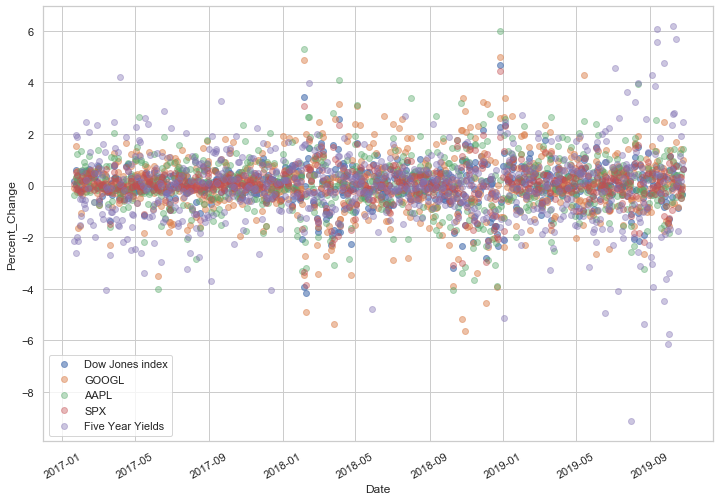

In [63]:
def ImportData(name = "^DJI",source='yahoo',start =datetime.date(2017,1,20), end = datetime.date(2019,10,25) ):
    '''
    This function takes a ticker symbol from a financial data source (yahoo as default), gathering
    daily data from a range start to end.
    
    #### input variables ####
    
        name: the ticker symbol of the stock/index

        source: financial database

        start: starting time of the stock data that the user requests

        end: ending time of the stock data that the user requests 
    
    #### output ####
    
        df: a data frame includes high,low,open,close,volume,adj close, percent_change
    
    ## Attributes ##
    
        high: highest price during the day

        low: lowest price during the day

        open: opening price at 9:30 am

        close: closing price at 4:00 pm

        volume: amount of trading that day

        adj close: I don't really know

        percent_change: (high-low)/open --> this percent_change represents the most volatility of the day
                
        Rise (categorical): if percent_change > 0
        
        Date: the date

        Volatile (categorical): whether the stock experiences huge change on that day, (high-low)/((high+low)/2) > 5%
    
    '''

    df = web.DataReader(name,source,start,end)
    df['Percent_change'] = (df.Close-df.Open)/df.Open*100
    df['Percent_change1'] = (df.Close-df.Open)/df.Open*100

    df['Date'] = df.index
    df['Date'] = pd.to_datetime(df['Date']).dt.date
    
    #Change index name to avoid confusion
    df.index.name = "Index"
    
    #sort df according to Date
    df = df.sort_values('Date',ascending=False)

    ### Define the 'Rise' attribute ###
    rise_array = []
    volatile_array = []
    
    percent_mean = np.mean(df['Percent_change'])
    percent_std = np.std(df['Percent_change'])
    volatility_bar = percent_mean + 2*percent_std
    
    for i in range(len(df)):
        if df.iloc[i]['Percent_change']>0:
            rise_array.append(1)
        else:
            rise_array.append(0)
            
        if np.abs(df.iloc[i]['Percent_change'])>volatility_bar:
            volatile_array.append(1)
        else:
            volatile_array.append(0)
            
            
    df['Rise'] = rise_array
    df['Volatile'] = volatile_array
    return df

DJI_data = ImportData('^DJI','yahoo')
AAPL_data = ImportData('AAPL','yahoo')
GOOGL_data = ImportData('GOOGL','yahoo')
df_SPX = ImportData("^GSPC",'yahoo')
FV = ImportData("^FVX",'yahoo')

display(df_SPX.describe())

fig,ax = plt.subplots(1,1,figsize=(12,8))

ax.plot(DJI_data.Date,DJI_data.Percent_change,'o',label = "Dow Jones index",alpha = 0.6)
ax.plot(GOOGL_data.Date,GOOGL_data.Percent_change,'o',label = 'GOOGL',alpha = 0.5)
ax.plot(AAPL_data.Date,AAPL_data.Percent_change,'o',label = 'AAPL',alpha = 0.4)
ax.plot(df_SPX.Date,df_SPX.Percent_change,'o',label = 'SPX',alpha = 0.4)
ax.plot(FV.Date,FV.Percent_change,'o',label = 'Five Year Yields',alpha = 0.4)

ax.set_xlabel("Date")
ax.set_ylabel("Percent_Change")
ax.legend()
plt.xticks(rotation = 30)
plt.show()


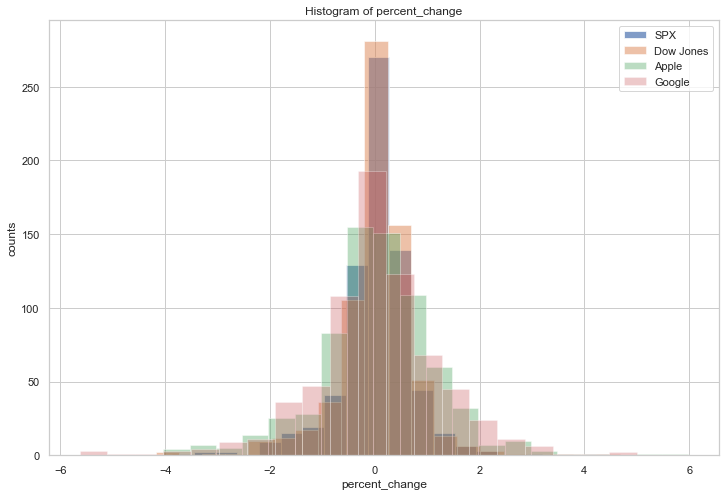

In [18]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(df_SPX.Percent_change1,bins=20,label = 'SPX',alpha=0.7)
ax.hist(DJI_data.Percent_change1,bins=20,label = 'Dow Jones',alpha=0.5)

ax.hist(AAPL_data.Percent_change1,bins=20,label = 'Apple',alpha = 0.4)

ax.hist(GOOGL_data.Percent_change1,bins=20,label = 'Google',alpha = 0.3)

ax.set_xlabel('percent_change')
ax.set_ylabel('counts')
ax.legend()
ax.set_title('Histogram of percent_change')
plt.show()

## Combine Tweet and Market Data into a Single Dataset

1. Create a column named trade_date_flag in tweet dataset to indicate whether the date is a trade-day or not

2. Create a combined dataset df_cbm based on df_SPX and add three columns:`trump_tweet_cnt`,`retweet_count`, and `favorite_count`, which indicate the number of tweets Trump tweeted, the number of retweets of Trump's tweets and the number of likes in a particular day



In [19]:
df_tweets_aggr['trade_date_flag'] = [1 if dt in df_SPX['Date'].values else 0 for dt in df_tweets_aggr['created_at']]

df_cbm = df_SPX.copy()
df_cbm['trump_tweet_cnt'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['trump_tweet_cnt'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['retweet_count'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['retweet_count'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['favorite_count'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['favorite_count'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['polarity'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['polarity'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['trade_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['trade_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['politics_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['politics_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]
df_cbm['foreign_tags_score'] = [df_tweets_aggr.loc[df_tweets_aggr['created_at']==dt]['foreign_tags_score'].values[0] if dt in (df_tweets_aggr['created_at'].values) else 0 for dt in df_SPX['Date'].values]

display(df_cbm.head())
display(df_cbm.describe())

High          Low         Open        Close      Volume    Adj Close  Percent_change  Percent_change1        Date  Rise  Volatile  trump_tweet_cnt  retweet_count  favorite_count  polarity  trade_tags_score  politics_tags_score  foreign_tags_score
Index                                                                                                                                                                                                                                                                    
2019-10-25  3027.389893  3001.939941  3003.320068  3022.550049  3370370000  3022.550049        0.640291         0.640291  2019-10-25     1         0                1        74119.0         76475.0       3.1                 0                    4                   0
2019-10-24  3016.070068  3000.419922  3014.780029  3010.290039  3692600000  3010.290039       -0.148933        -0.148933  2019-10-24     0         0                9       203529.0        518594.0       1.6                 0                    1                   3
2019-10-23  3004.780029  2991.209961  2994.010010  3004.520020  3392870000  3004.520020        0.351035         0.351035  2019-10-23     1         0               22       604261.0       1292485.0      21.1                 4                   11                   5
2019-10-22  3014.570068  2995.040039  3010.729980  2995.989990  3523890000  2995.989990       -0.489582        -0.489582  2019-10-22     0         0               14       504930.0       1022161.0      -1.2                 2                    9                   3
2019-10-21  3007.330078  2995.350098  2996.479980  3006.719971  3271620000  3006.719971        0.341734         0.341734  2019-10-21     1         0               12       251644.0        645387.0      10.9                 0                    2                   0

High          Low         Open        Close        Volume    Adj Close  Percent_change  Percent_change1        Rise    Volatile  trump_tweet_cnt  retweet_count  favorite_count    polarity  trade_tags_score  politics_tags_score  foreign_tags_score
count   697.000000   697.000000   697.000000   697.000000  6.970000e+02   697.000000      697.000000       697.000000  697.000000  697.000000       697.000000     697.000000    6.970000e+02  697.000000        697.000000           697.000000          697.000000
mean   2693.957344  2670.310731  2682.767102  2682.893888  3.521506e+09  2682.893888        0.008258         0.008258    0.542324    0.064562         9.423242  215300.238164    7.999754e+05    5.574462          3.251076             1.548063            1.179340
std     202.313275   199.377846   201.000998   200.660956  5.920275e+08   200.660956        0.701529         0.701529    0.498563    0.245929         6.008871  139979.556020    4.639871e+05   10.739617          8.715743             2.086024            2.389688
min    2271.780029  2257.020020  2267.780029  2265.199951  1.349780e+09  2265.199951       -3.873729        -3.873729    0.000000    0.000000         0.000000       0.000000    0.000000e+00  -43.300000          0.000000             0.000000            0.000000
25%    2507.159912  2490.370117  2497.260010  2500.229980  3.192510e+09  2500.229980       -0.227788        -0.227788    0.000000    0.000000         5.000000  110053.000000    4.484820e+05   -0.400000          0.000000             0.000000            0.000000
50%    2730.600098  2698.750000  2714.989990  2712.969971  3.437620e+09  2712.969971        0.038244         0.038244    1.000000    0.000000         8.000000  193206.000000    7.269610e+05    4.200000          0.000000             1.000000            0.000000
75%    2858.679932  2830.939941  2846.199951  2847.110107  3.770520e+09  2847.110107        0.346609         0.346609    1.000000    0.000000        13.000000  286056.000000    1.077062e+06   11.500000          2.000000             2.000000            1.000000
max    3027.979980  3014.300049  3024.469971  3025.860107  7.609010e+09  3025.860107        4.425498         4.425498    1.000000    1.000000        36.000000  789785.000000    2.639593e+06   59.600000        119.000000            15.000000           26.000000

# EDA and Baseline Model

1. We first perform a scatter plot on all the columns of the combined data frame. At first glance, `high`,`low`,`open`,`close`and `adj close` have some linear relationship with `trump_tweet_cnt`,`retweet_count`, and `favorite_count`. Other columns that are not directly reflecting the price, such as `volume` and `percent_change` seem to be unrelated to `trump_tweet_cnt`,`retweet_count`, or `favorite_count`. 


2. Therefore, we performed a simple linear regression model using `trump_tweet_cnt`, `retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculated the score. The score for the training set is 0.310 and the score for the test set is 0.340. These are pretty bad scores, so we will further process the data and then do the fitting. Lasso regularization can be implemented in the future, too.


3. Then we perform a series of k-NN model using `trump_tweet_cnt`,`retweet_count`, and `favorite_count` as predictors and `high` as response variable and calculate the score. The best scores we get is when number of neighbors is 20. The training set_score is  0.350. The test set score is 0.346.

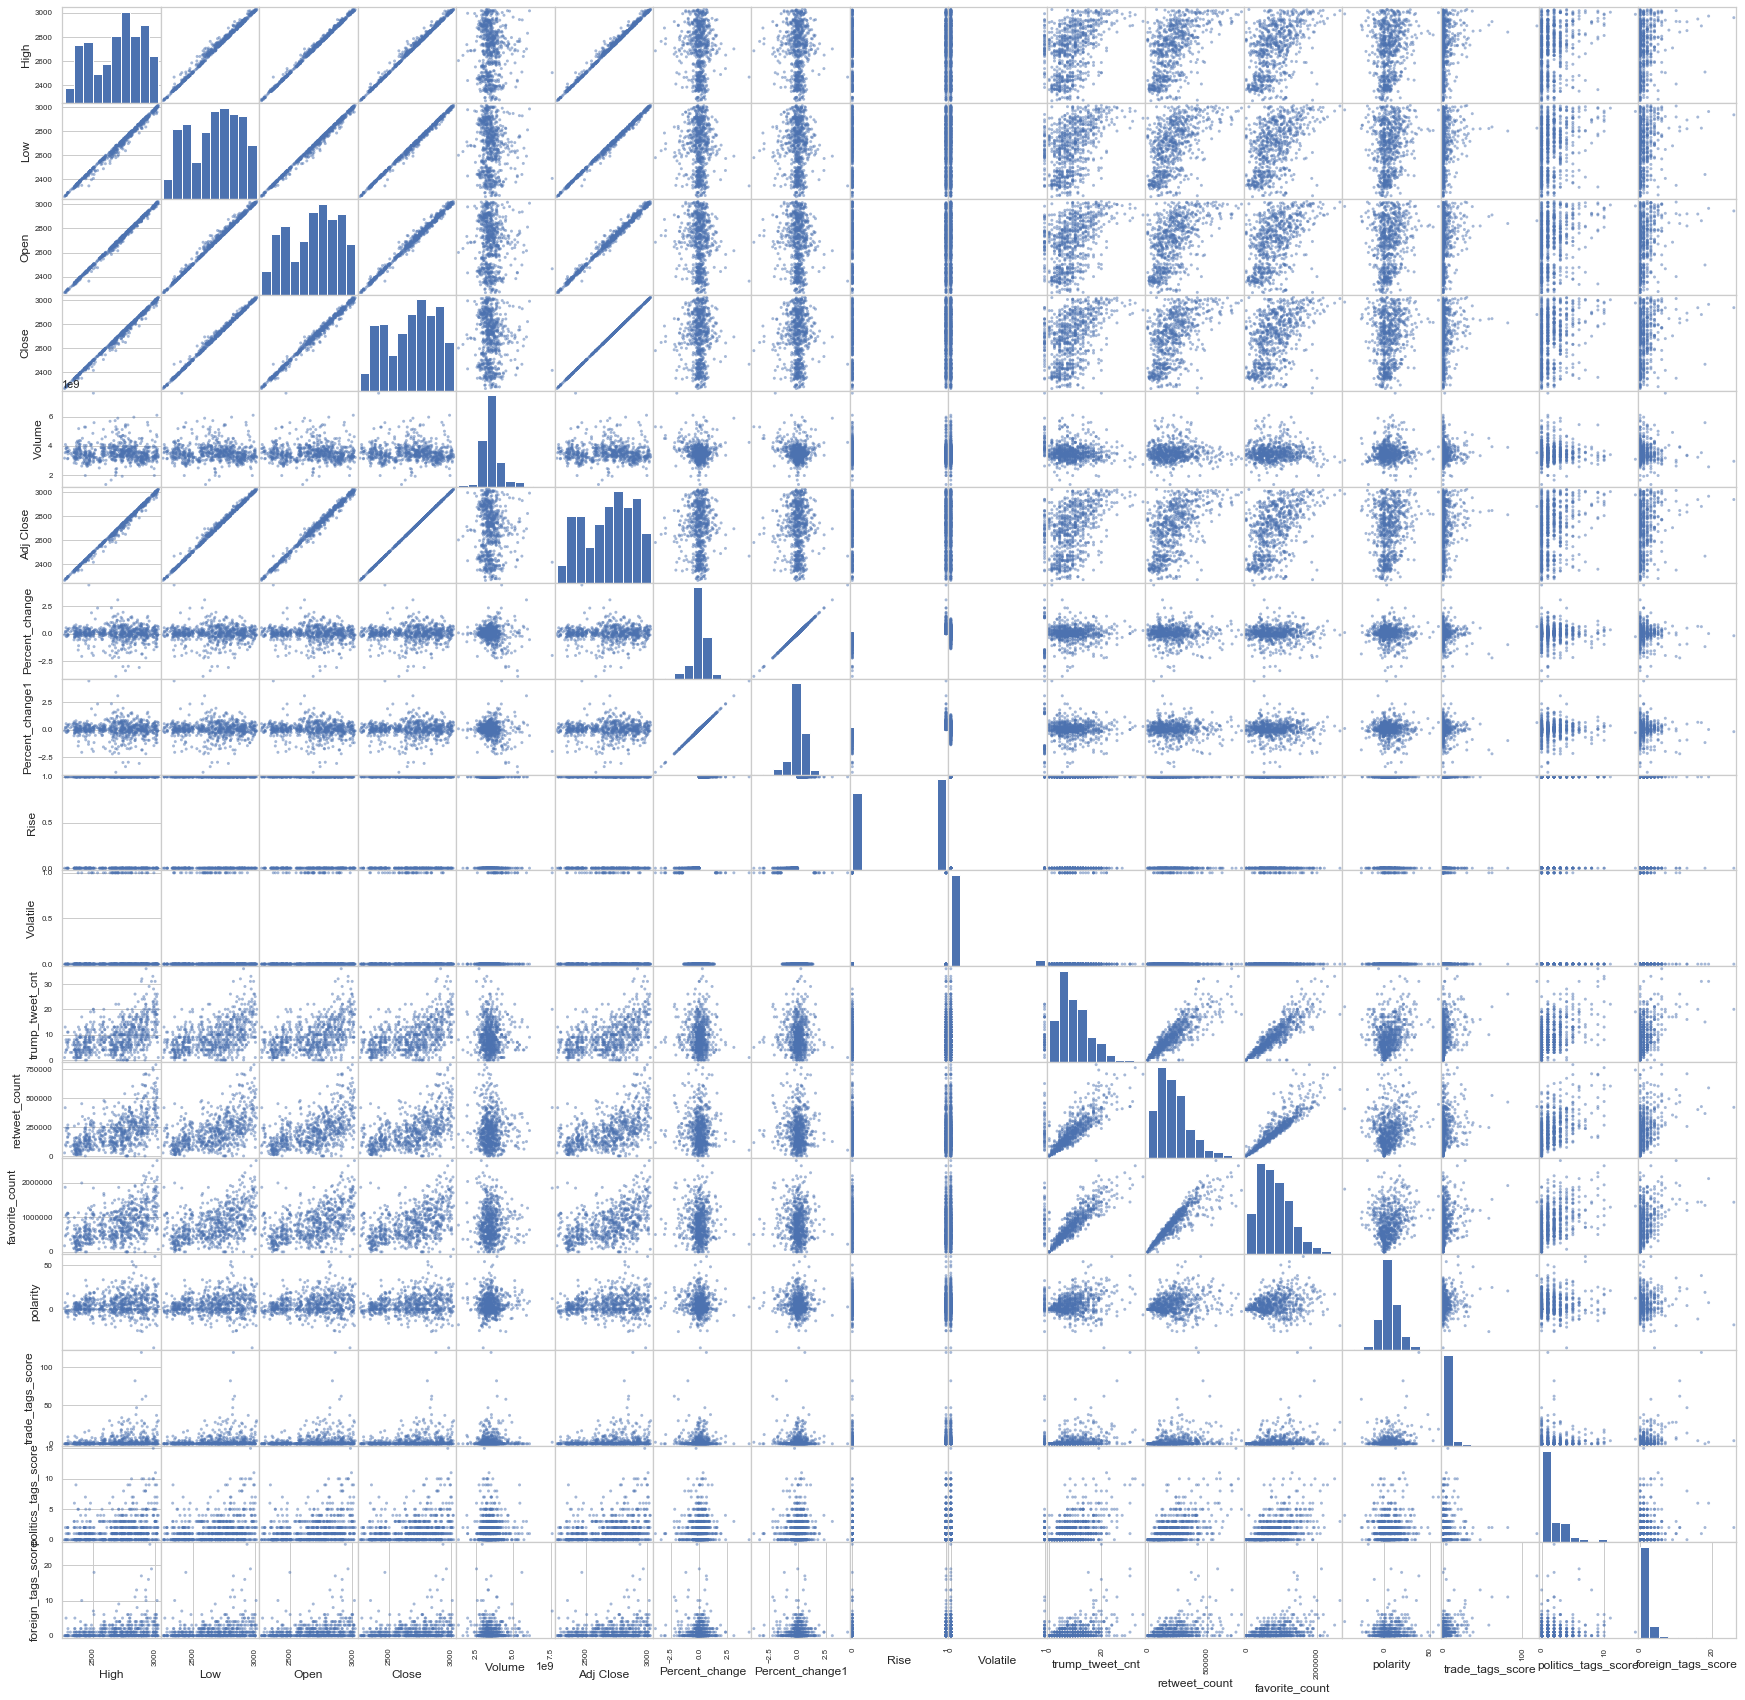

In [20]:
scatter_matrix(df_cbm,figsize=(30,30))
plt.savefig('./scatter_pair.png')
plt.show()

In [21]:
combined_df = pd.merge(left=df_tweets_aggr, right=df_SPX, how='left', left_on='created_at', right_on='Date')
combined_df.head()

created_at  trump_tweet_cnt  trump_retweet_cnt  retweet_count  favorite_count  polarity  trade_tags_score  politics_tags_score  foreign_tags_score  trade_date_flag         High          Low         Open        Close        Volume    Adj Close  Percent_change  Percent_change1        Date  Rise  Volatile
0  2017-01-20               13                  0       417567.0       1867501.0       7.6                 0                    0                   0                1  2276.959961  2265.010010  2269.959961  2271.310059  3.524970e+09  2271.310059        0.059477         0.059477  2017-01-20   1.0       0.0
1  2017-01-21                2                  1       103818.0        467521.0       5.3                 0                    0                   0                0          NaN          NaN          NaN          NaN           NaN          NaN             NaN              NaN         NaN   NaN       NaN
2  2017-01-22                4                  0       184236.0        949408.0       6.6                 0                    0                   0                0          NaN          NaN          NaN          NaN           NaN          NaN             NaN              NaN         NaN   NaN       NaN
3  2017-01-23                1                  0        26750.0        177839.0       1.4                 0                    0                   0                1  2271.780029  2257.020020  2267.780029  2265.199951  3.152710e+09  2265.199951       -0.113771        -0.113771  2017-01-23   0.0       0.0
4  2017-01-24                4                  0        86707.0        495813.0      -1.2                 0                    0                   0                1  2284.629883  2266.679932  2267.879883  2280.070068  3.810960e+09  2280.070068        0.537515         0.537515  2017-01-24   1.0       0.0

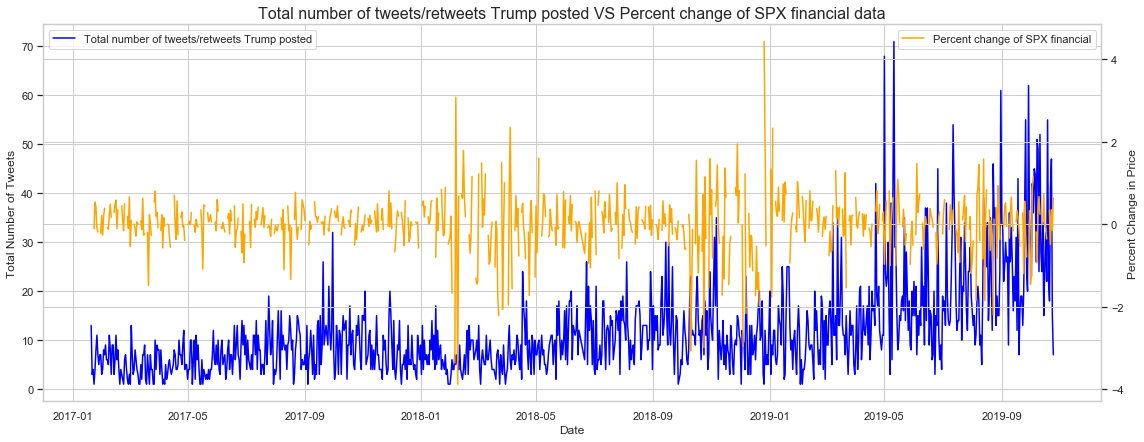

In [22]:
fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(combined_df['created_at'],combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], color='blue', label='Total number of tweets/retweets Trump posted')
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Number of Tweets")
plt.legend()
ax2 = ax1.twinx()
ax2.set_ylabel("Percent Change in Price")
ax2.plot(combined_df['created_at'], combined_df['Percent_change'], color='orange', label='Percent change of SPX financial')
fig.tight_layout() 

plt.title('Total number of tweets/retweets Trump posted VS Percent change of SPX financial data', fontsize=16)
plt.legend()
plt.show()

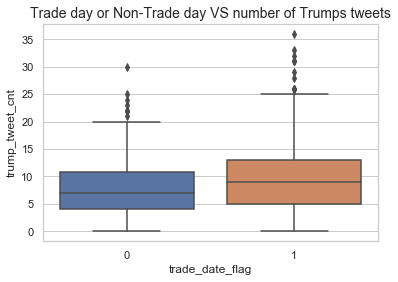

In [23]:
sns.boxplot(x = 'trade_date_flag', y = 'trump_tweet_cnt', data = combined_df)
plt.title('Trade day or Non-Trade day VS number of Trumps tweets', fontsize=14)
plt.show()

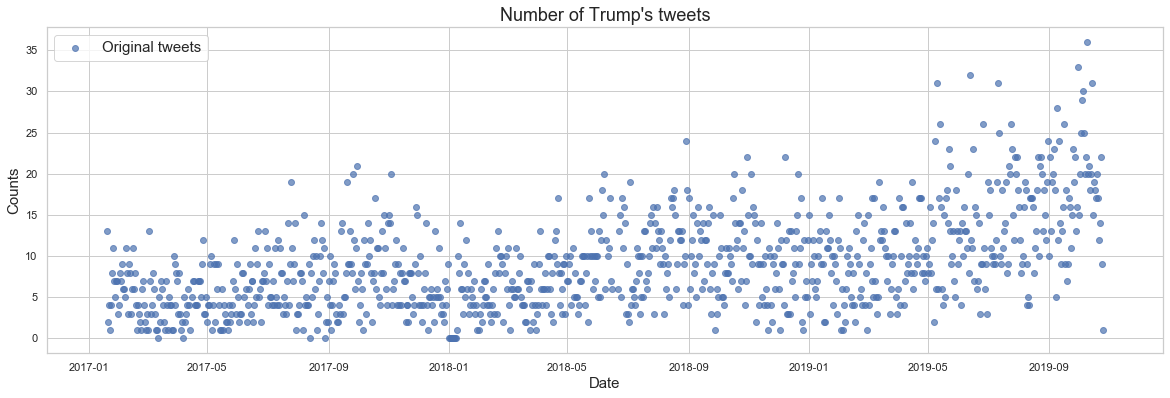

In [24]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['trump_tweet_cnt'], color='b',alpha=0.7, label='Original tweets')
#ax.scatter(combined_df['created_at'], combined_df['trump_retweet_cnt'], color='r', alpha=0.7, label='Retweets by Trump')
#ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color = 'orange', label = 'Retweets from Trump')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Number of Trump\'s tweets', fontsize=18)
plt.legend(fontsize = 15)
plt.show()

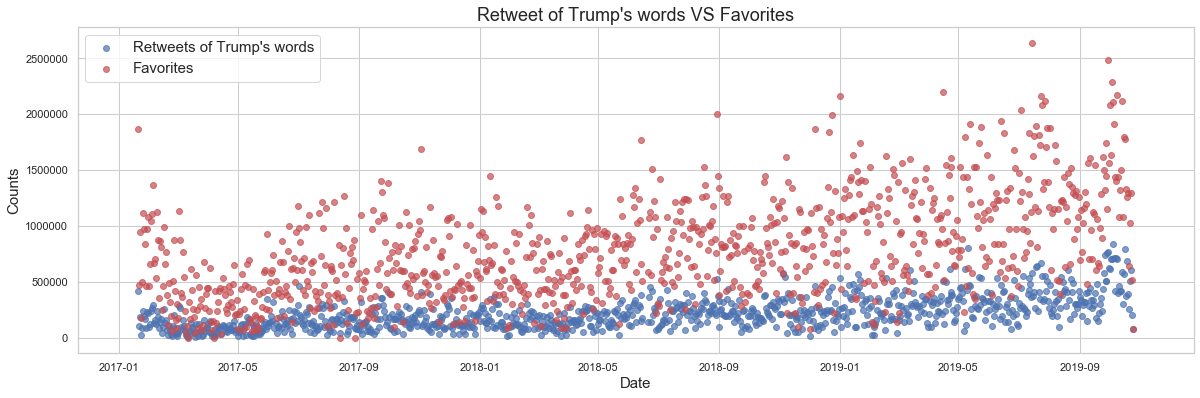

In [25]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color='b',alpha=0.7, label='Retweets of Trump\'s words')
ax.scatter(combined_df['created_at'], combined_df['favorite_count'], color='r', alpha=0.7, label='Favorites')
#ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color = 'orange', label = 'Retweets from Trump')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Retweet of Trump\'s words VS Favorites', fontsize=18)
plt.legend(fontsize = 15)
plt.show()

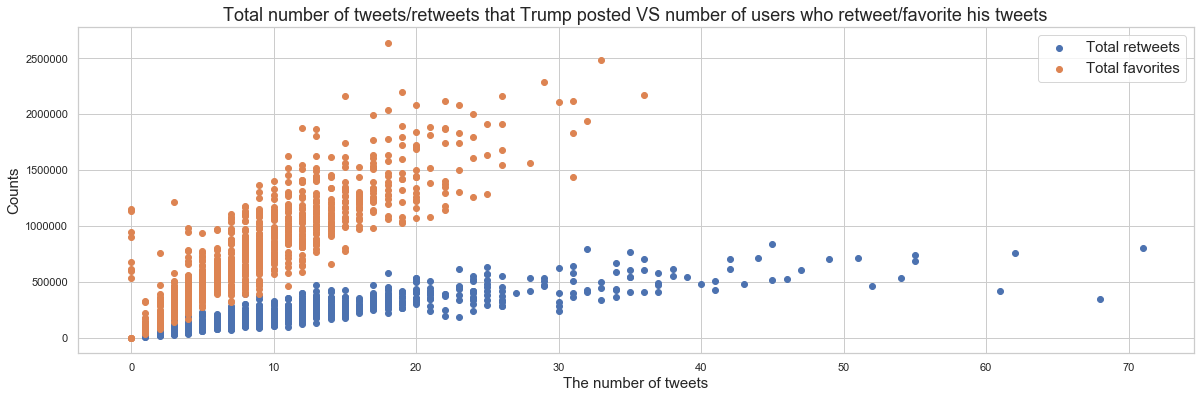

In [26]:
# used in the result analysis part
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['trump_tweet_cnt'] + combined_df['trump_retweet_cnt'], combined_df['retweet_count'], label="Total retweets")
ax.scatter(combined_df['trump_tweet_cnt'], combined_df['favorite_count'], label="Total favorites")
ax.set_xlabel("The number of tweets",fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15)
plt.title('Total number of tweets/retweets that Trump posted VS number of users who retweet/favorite his tweets', fontsize=18)
plt.legend(fontsize = 15)
plt.show()

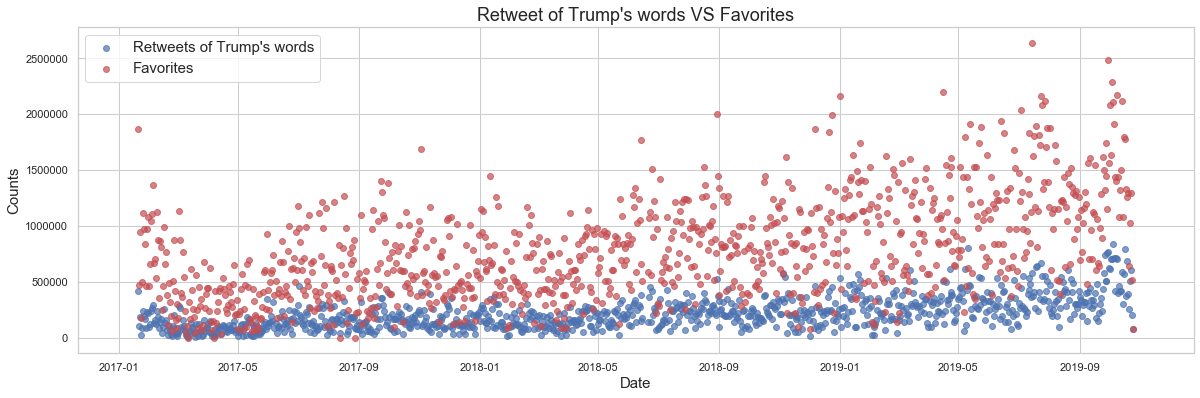

In [27]:
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(combined_df['created_at'], combined_df['retweet_count'], color='b',alpha=0.7, label='Retweets of Trump\'s words')
ax.scatter(combined_df['created_at'], combined_df['favorite_count'], color='r', alpha=0.7, label='Favorites')
ax.set_xlabel("Date", fontsize = 15)
ax.set_ylabel("Counts",fontsize = 15 )
plt.title('Retweet of Trump\'s words VS Favorites', fontsize=18)
plt.legend(fontsize = 15)
#plt.savefig('/Users/YuhanZhang/Desktop/tweet_2.png')
plt.show()

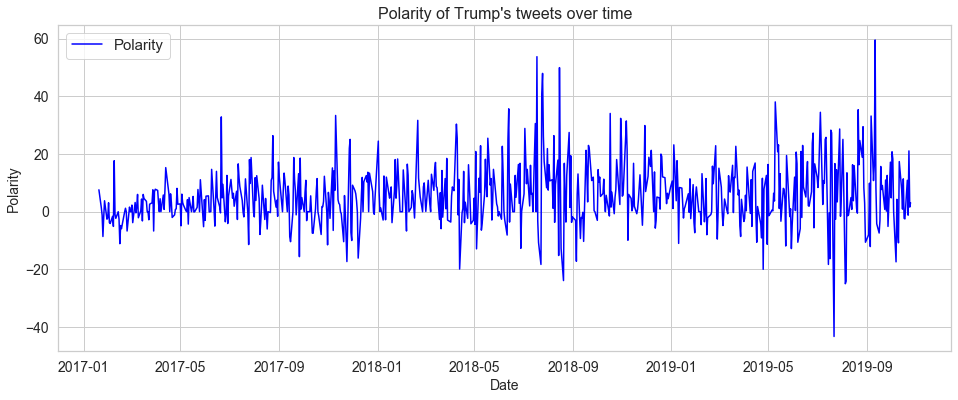

In [28]:
#2019-12-10 New

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(df_cbm['Date'],df_cbm['polarity'], color='blue', label='Polarity')
ax1.set_xlabel("Date",fontsize=14)
ax1.set_ylabel("Polarity",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Polarity of Trump\'s tweets over time' , fontsize=16)
plt.legend(fontsize = 15)
plt.show()

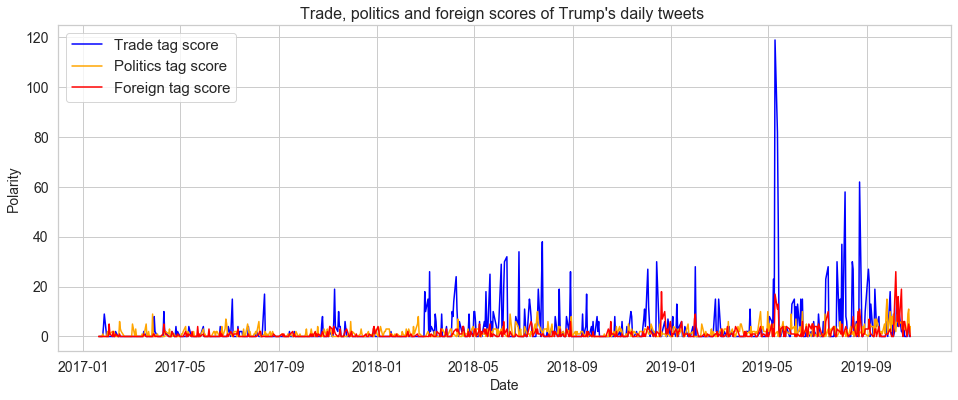

In [29]:

fig, ax1 = plt.subplots(figsize=(16,6))
ax1.plot(df_cbm['Date'],df_cbm['trade_tags_score'], color='blue', label='Trade tag score')
ax1.plot(df_cbm['Date'],df_cbm['politics_tags_score'],color='orange',  label='Politics tag score')
ax1.plot(df_cbm['Date'],df_cbm['foreign_tags_score'],color='red', label='Foreign tag score')

ax1.set_xlabel("Date",fontsize=14)
ax1.set_ylabel("Polarity",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trade, politics and foreign scores of Trump\'s daily tweets ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()

## Basic modelling

In [30]:


#df_cbm = df_cbm.iloc[17:] #only run once to drop the row of zeros

display(df_cbm.describe())

x = df_cbm[['trump_tweet_cnt','retweet_count','favorite_count','polarity','trade_tags_score','politics_tags_score','foreign_tags_score']]

y = df_cbm['High']

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

reg = LinearRegression().fit(X_train,y_train)
train_score = reg.score(X_train,y_train)
test_score = reg.score(X_test,y_test)
print("The training set_score is ",train_score,". The test set score is",test_score)

display(X_train.head())

High          Low         Open        Close        Volume    Adj Close  Percent_change  Percent_change1        Rise    Volatile  trump_tweet_cnt  retweet_count  favorite_count    polarity  trade_tags_score  politics_tags_score  foreign_tags_score
count   697.000000   697.000000   697.000000   697.000000  6.970000e+02   697.000000      697.000000       697.000000  697.000000  697.000000       697.000000     697.000000    6.970000e+02  697.000000        697.000000           697.000000          697.000000
mean   2693.957344  2670.310731  2682.767102  2682.893888  3.521506e+09  2682.893888        0.008258         0.008258    0.542324    0.064562         9.423242  215300.238164    7.999754e+05    5.574462          3.251076             1.548063            1.179340
std     202.313275   199.377846   201.000998   200.660956  5.920275e+08   200.660956        0.701529         0.701529    0.498563    0.245929         6.008871  139979.556020    4.639871e+05   10.739617          8.715743             2.086024            2.389688
min    2271.780029  2257.020020  2267.780029  2265.199951  1.349780e+09  2265.199951       -3.873729        -3.873729    0.000000    0.000000         0.000000       0.000000    0.000000e+00  -43.300000          0.000000             0.000000            0.000000
25%    2507.159912  2490.370117  2497.260010  2500.229980  3.192510e+09  2500.229980       -0.227788        -0.227788    0.000000    0.000000         5.000000  110053.000000    4.484820e+05   -0.400000          0.000000             0.000000            0.000000
50%    2730.600098  2698.750000  2714.989990  2712.969971  3.437620e+09  2712.969971        0.038244         0.038244    1.000000    0.000000         8.000000  193206.000000    7.269610e+05    4.200000          0.000000             1.000000            0.000000
75%    2858.679932  2830.939941  2846.199951  2847.110107  3.770520e+09  2847.110107        0.346609         0.346609    1.000000    0.000000        13.000000  286056.000000    1.077062e+06   11.500000          2.000000             2.000000            1.000000
max    3027.979980  3014.300049  3024.469971  3025.860107  7.609010e+09  3025.860107        4.425498         4.425498    1.000000    1.000000        36.000000  789785.000000    2.639593e+06   59.600000        119.000000            15.000000           26.000000

The training set_score is  0.3055479428994057 . The test set score is 0.2621202224564284


trump_tweet_cnt  retweet_count  favorite_count  polarity  trade_tags_score  politics_tags_score  foreign_tags_score
Index                                                                                                                          
2019-07-01               19       308622.0       1472199.0      12.0                 0                    0                   4
2019-08-14               17       384068.0       1231423.0      16.3                30                    1                   4
2018-12-11               13       266889.0       1165368.0      13.8                 2                    2                   1
2017-08-08                4       125388.0        380389.0      -7.9                 0                    1                   2
2018-01-10               10       188835.0        821099.0       6.0                 0                    2                   0

### Normalize Data

In [31]:
from sklearn import preprocessing

# fit the scaler on the X_train
scaler = preprocessing.MinMaxScaler().fit(X_train)

# Scale X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Making the numpy scaled matrices pandas dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled_df.head()

trump_tweet_cnt  retweet_count  favorite_count  polarity  trade_tags_score  politics_tags_score  foreign_tags_score
Index                                                                                                                          
2019-07-01         0.527778       0.404198        0.557737  0.537415          0.000000             0.000000            0.153846
2019-08-14         0.472222       0.503008        0.466520  0.579203          0.252101             0.066667            0.153846
2018-12-11         0.361111       0.349541        0.441495  0.554908          0.016807             0.133333            0.038462
2017-08-08         0.111111       0.164219        0.144109  0.344023          0.000000             0.066667            0.076923
2018-01-10         0.277778       0.247314        0.311070  0.479106          0.000000             0.133333            0.000000

#### Update model with normalized data

In [32]:
reg_scaled = LinearRegression().fit(X_train_scaled_df,y_train)
train_score_scaled = reg.score(X_train_scaled_df,y_train)
test_score_scaled = reg.score(X_test_scaled_df,y_test)
print("The training set score is ",train_score_scaled,". The test set score is",test_score_scaled)

The training set score is  -0.669889434957553 . The test set score is -0.9702022784633095


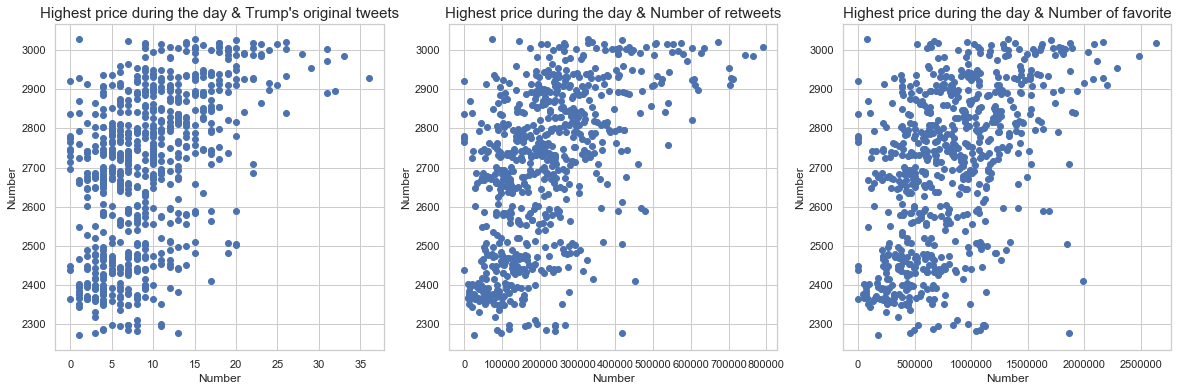

In [33]:
fig, ax = plt.subplots(1,3, figsize = (20,6))
predictor = list(['trump_tweet_cnt','retweet_count','favorite_count'])
name = ['Trump\'s original tweets', 'Number of retweets', 'Number of favorite']
for i, item in enumerate(predictor):
    ax[i].scatter(df_cbm[item], y)
    ax[i].set_title('Highest price during the day & {}'.format(name[i]), fontsize = 15)
    ax[i].set_xlabel('Number')
    ax[i].set_ylabel('Number')



The number of neighbors is 1 The training set_score is  0.9867709397706813 . The test set score is -0.423347016620073
The number of neighbors is 2 The training set_score is  0.7023025553252018 . The test set score is 0.030451099410673917
The number of neighbors is 3 The training set_score is  0.5885100128545917 . The test set score is 0.15291238659357276
The number of neighbors is 5 The training set_score is  0.474554773512725 . The test set score is 0.20218153304656494
The number of neighbors is 6 The training set_score is  0.4551624558756089 . The test set score is 0.23168312467101237
The number of neighbors is 7 The training set_score is  0.4411205824111237 . The test set score is 0.2412945126522704
The number of neighbors is 8 The training set_score is  0.4183815227032589 . The test set score is 0.2567931752506959
The number of neighbors is 10 The training set_score is  0.3852110585550283 . The test set score is 0.253274077099936
The number of neighbors is 20 The training set_score

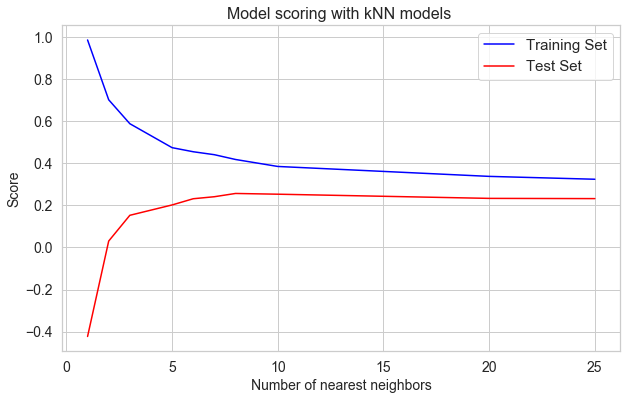

In [34]:
k_list = [1,2,3,5,6,7,8,10,20,25]
train_score_set = []
test_score_set = []
for k in k_list:
    kNN = KNeighborsRegressor(n_neighbors = k).fit(X_train,y_train)

    train_score = kNN.score(X_train,y_train)
    test_score = kNN.score(X_test,y_test)
    train_score_set.append(train_score)
    test_score_set.append(test_score)
    print("The number of neighbors is",k,"The training set_score is ",train_score,". The test set score is",test_score)
    
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(k_list,train_score_set, color='blue', label='Training Set')
ax1.plot(k_list,test_score_set,color='red',  label='Test Set')

ax1.set_xlabel("Number of nearest neighbors",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Model scoring with kNN models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()

# Tree Model Fitting



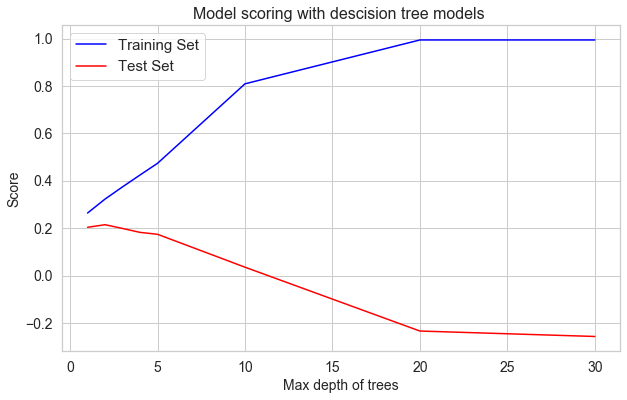

In [35]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,accuracy_score

max_depth = [1,2,3,4,5,10,20,30]
tree_models = []
tree_train_score = []
tree_cross_score = []
tree_test_score = []
for depth in max_depth:
    
    dtree = DecisionTreeRegressor(max_depth=depth)
    dtree.fit(X_train,y_train)
    train_score = dtree.score(X_train,y_train)
    cross_scores = np.mean(cross_val_score(dtree,X_train,y_train,cv=5))
    tree_models.append(dtree)
    tree_train_score.append(train_score)
    tree_cross_score.append(cross_scores)
    tree_test_score.append(dtree.score(X_test,y_test))

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(max_depth,tree_train_score, color='blue', label='Training Set')
ax1.plot(max_depth,tree_test_score,color='red',  label='Test Set')

ax1.set_xlabel("Max depth of trees",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Model scoring with descision tree models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()


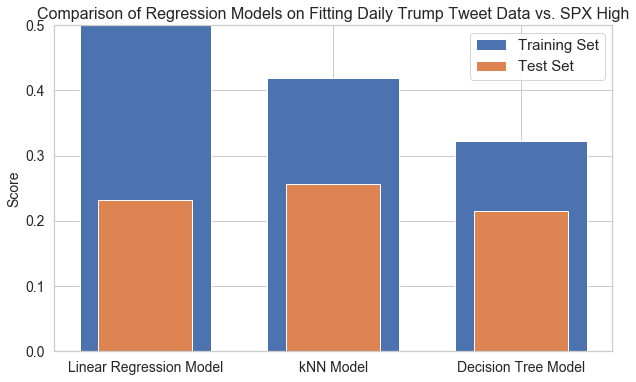

In [36]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

ax.bar(['Linear Regression Model','kNN Model','Decision Tree Model'],[train_score,train_score_set[6],tree_train_score[1]],label='Training Set',width=0.7)
ax.bar(['Linear Regression Model','kNN Model','Decision Tree Model'],[test_score,test_score_set[6],tree_test_score[1]],label='Test Set',width=0.5)
ax.legend(fontsize=15)
ax.set_ylabel("Score",fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylim(0,0.5)
ax.set_title('Comparison of Regression Models on Fitting Daily Trump Tweet Data vs. SPX High',fontsize=16)
plt.show()


### ANN



In [37]:
import tensorflow as tf


In [38]:
input_dimension = X_train.shape[1]
output_dimension = 1
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_dim = input_dimension,kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(15,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(10,activation = 'relu',kernel_initializer = 'normal'),

    tf.keras.layers.Dense(output_dimension,activation = 'linear'),

])

model.compile(optimizer = 'adam',loss='mean_absolute_error',metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train,validation_split=0.2,epochs=500,batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                80        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 1,156
Trainable params: 1,156
Non-trainable params: 0
______________________________________________________

445/445 [==============================] - 0s 40us/sample - loss: 1121.8887 - accuracy: 0.0000e+00 - val_loss: 1074.8588 - val_accuracy: 0.0000e+00
Epoch 44/500
445/445 [==============================] - 0s 40us/sample - loss: 1126.4958 - accuracy: 0.0000e+00 - val_loss: 1077.3468 - val_accuracy: 0.0000e+00
Epoch 45/500
445/445 [==============================] - 0s 40us/sample - loss: 1140.6089 - accuracy: 0.0000e+00 - val_loss: 1079.4568 - val_accuracy: 0.0000e+00
Epoch 46/500
445/445 [==============================] - 0s 41us/sample - loss: 1121.9014 - accuracy: 0.0000e+00 - val_loss: 1078.5839 - val_accuracy: 0.0000e+00
Epoch 47/500
445/445 [==============================] - 0s 40us/sample - loss: 1122.8659 - accuracy: 0.0000e+00 - val_loss: 1075.5648 - val_accuracy: 0.0000e+00
Epoch 48/500
445/445 [==============================] - 0s 40us/sample - loss: 1124.4881 - accuracy: 0.0000e+00 - val_loss: 1075.8555 - val_accuracy: 0.0000e+00
Epoch 49/500
445/445 [=========================

Epoch 94/500
445/445 [==============================] - 0s 44us/sample - loss: 1116.6282 - accuracy: 0.0000e+00 - val_loss: 1071.7713 - val_accuracy: 0.0000e+00
Epoch 95/500
445/445 [==============================] - 0s 43us/sample - loss: 1123.9855 - accuracy: 0.0000e+00 - val_loss: 1073.1793 - val_accuracy: 0.0000e+00
Epoch 96/500
445/445 [==============================] - 0s 39us/sample - loss: 1139.2509 - accuracy: 0.0000e+00 - val_loss: 1072.7088 - val_accuracy: 0.0000e+00
Epoch 97/500
445/445 [==============================] - 0s 42us/sample - loss: 1125.6033 - accuracy: 0.0000e+00 - val_loss: 1079.0000 - val_accuracy: 0.0000e+00
Epoch 98/500
445/445 [==============================] - 0s 40us/sample - loss: 1123.0520 - accuracy: 0.0000e+00 - val_loss: 1075.7128 - val_accuracy: 0.0000e+00
Epoch 99/500
445/445 [==============================] - 0s 39us/sample - loss: 1111.7361 - accuracy: 0.0000e+00 - val_loss: 1080.7087 - val_accuracy: 0.0000e+00
Epoch 100/500
445/445 [===========

445/445 [==============================] - 0s 42us/sample - loss: 1111.2154 - accuracy: 0.0000e+00 - val_loss: 1069.0153 - val_accuracy: 0.0000e+00
Epoch 145/500
445/445 [==============================] - 0s 40us/sample - loss: 1119.1686 - accuracy: 0.0000e+00 - val_loss: 1074.7963 - val_accuracy: 0.0000e+00
Epoch 146/500
445/445 [==============================] - 0s 41us/sample - loss: 1120.6008 - accuracy: 0.0000e+00 - val_loss: 1075.2116 - val_accuracy: 0.0000e+00
Epoch 147/500
445/445 [==============================] - 0s 40us/sample - loss: 1119.9826 - accuracy: 0.0000e+00 - val_loss: 1068.9688 - val_accuracy: 0.0000e+00
Epoch 148/500
445/445 [==============================] - 0s 43us/sample - loss: 1113.2558 - accuracy: 0.0000e+00 - val_loss: 1068.7867 - val_accuracy: 0.0000e+00
Epoch 149/500
445/445 [==============================] - 0s 41us/sample - loss: 1110.0447 - accuracy: 0.0000e+00 - val_loss: 1068.4201 - val_accuracy: 0.0000e+00
Epoch 150/500
445/445 [===================

Epoch 195/500
445/445 [==============================] - 0s 81us/sample - loss: 1102.0751 - accuracy: 0.0000e+00 - val_loss: 1105.6986 - val_accuracy: 0.0000e+00
Epoch 196/500
445/445 [==============================] - 0s 146us/sample - loss: 1099.8548 - accuracy: 0.0000e+00 - val_loss: 1126.4924 - val_accuracy: 0.0000e+00
Epoch 197/500
445/445 [==============================] - 0s 54us/sample - loss: 1111.2176 - accuracy: 0.0000e+00 - val_loss: 1122.6668 - val_accuracy: 0.0000e+00
Epoch 198/500
445/445 [==============================] - 0s 56us/sample - loss: 1102.5615 - accuracy: 0.0000e+00 - val_loss: 1103.6483 - val_accuracy: 0.0000e+00
Epoch 199/500
445/445 [==============================] - 0s 46us/sample - loss: 1117.6797 - accuracy: 0.0000e+00 - val_loss: 1122.4763 - val_accuracy: 0.0000e+00
Epoch 200/500
445/445 [==============================] - 0s 43us/sample - loss: 1110.4494 - accuracy: 0.0000e+00 - val_loss: 1102.6212 - val_accuracy: 0.0000e+00
Epoch 201/500
445/445 [====

445/445 [==============================] - 0s 47us/sample - loss: 1100.7452 - accuracy: 0.0000e+00 - val_loss: 1109.2002 - val_accuracy: 0.0000e+00
Epoch 246/500
445/445 [==============================] - 0s 45us/sample - loss: 1095.8215 - accuracy: 0.0000e+00 - val_loss: 1102.8187 - val_accuracy: 0.0000e+00
Epoch 247/500
445/445 [==============================] - 0s 49us/sample - loss: 1101.4900 - accuracy: 0.0000e+00 - val_loss: 1104.2505 - val_accuracy: 0.0000e+00
Epoch 248/500
445/445 [==============================] - 0s 59us/sample - loss: 1093.1725 - accuracy: 0.0000e+00 - val_loss: 1109.5594 - val_accuracy: 0.0000e+00
Epoch 249/500
445/445 [==============================] - 0s 101us/sample - loss: 1096.8075 - accuracy: 0.0000e+00 - val_loss: 1096.0626 - val_accuracy: 0.0000e+00
Epoch 250/500
445/445 [==============================] - 0s 107us/sample - loss: 1100.0558 - accuracy: 0.0000e+00 - val_loss: 1121.4202 - val_accuracy: 0.0000e+00
Epoch 251/500
445/445 [=================

445/445 [==============================] - 0s 56us/sample - loss: 1106.4287 - accuracy: 0.0000e+00 - val_loss: 1117.4902 - val_accuracy: 0.0000e+00
Epoch 296/500
445/445 [==============================] - 0s 59us/sample - loss: 1095.1665 - accuracy: 0.0000e+00 - val_loss: 1106.7350 - val_accuracy: 0.0000e+00
Epoch 297/500
445/445 [==============================] - 0s 57us/sample - loss: 1100.9522 - accuracy: 0.0000e+00 - val_loss: 1143.0645 - val_accuracy: 0.0000e+00
Epoch 298/500
445/445 [==============================] - 0s 47us/sample - loss: 1102.9507 - accuracy: 0.0000e+00 - val_loss: 1113.5160 - val_accuracy: 0.0000e+00
Epoch 299/500
445/445 [==============================] - 0s 48us/sample - loss: 1103.8501 - accuracy: 0.0000e+00 - val_loss: 1094.5621 - val_accuracy: 0.0000e+00
Epoch 300/500
445/445 [==============================] - 0s 46us/sample - loss: 1088.5877 - accuracy: 0.0000e+00 - val_loss: 1131.2994 - val_accuracy: 0.0000e+00
Epoch 301/500
445/445 [===================

Epoch 346/500
445/445 [==============================] - 0s 88us/sample - loss: 1089.4983 - accuracy: 0.0000e+00 - val_loss: 1108.3837 - val_accuracy: 0.0000e+00
Epoch 347/500
445/445 [==============================] - 0s 79us/sample - loss: 1084.2304 - accuracy: 0.0000e+00 - val_loss: 1115.7659 - val_accuracy: 0.0000e+00
Epoch 348/500
445/445 [==============================] - 0s 90us/sample - loss: 1090.0146 - accuracy: 0.0000e+00 - val_loss: 1113.7296 - val_accuracy: 0.0000e+00
Epoch 349/500
445/445 [==============================] - 0s 81us/sample - loss: 1091.1495 - accuracy: 0.0000e+00 - val_loss: 1116.0467 - val_accuracy: 0.0000e+00
Epoch 350/500
445/445 [==============================] - 0s 75us/sample - loss: 1087.8068 - accuracy: 0.0000e+00 - val_loss: 1127.2070 - val_accuracy: 0.0000e+00
Epoch 351/500
445/445 [==============================] - 0s 92us/sample - loss: 1085.0160 - accuracy: 0.0000e+00 - val_loss: 1104.5929 - val_accuracy: 0.0000e+00
Epoch 352/500
445/445 [=====

445/445 [==============================] - 0s 43us/sample - loss: 1082.3757 - accuracy: 0.0000e+00 - val_loss: 1115.0665 - val_accuracy: 0.0000e+00
Epoch 397/500
445/445 [==============================] - 0s 45us/sample - loss: 1083.1021 - accuracy: 0.0000e+00 - val_loss: 1123.3754 - val_accuracy: 0.0000e+00
Epoch 398/500
445/445 [==============================] - 0s 44us/sample - loss: 1085.5125 - accuracy: 0.0000e+00 - val_loss: 1108.0663 - val_accuracy: 0.0000e+00
Epoch 399/500
445/445 [==============================] - 0s 43us/sample - loss: 1085.1324 - accuracy: 0.0000e+00 - val_loss: 1129.6580 - val_accuracy: 0.0000e+00
Epoch 400/500
445/445 [==============================] - 0s 44us/sample - loss: 1087.8029 - accuracy: 0.0000e+00 - val_loss: 1107.6997 - val_accuracy: 0.0000e+00
Epoch 401/500
445/445 [==============================] - 0s 45us/sample - loss: 1082.0312 - accuracy: 0.0000e+00 - val_loss: 1114.1316 - val_accuracy: 0.0000e+00
Epoch 402/500
445/445 [===================

Epoch 447/500
445/445 [==============================] - 0s 45us/sample - loss: 1093.3072 - accuracy: 0.0000e+00 - val_loss: 1114.6082 - val_accuracy: 0.0000e+00
Epoch 448/500
445/445 [==============================] - 0s 44us/sample - loss: 1081.7501 - accuracy: 0.0000e+00 - val_loss: 1127.4468 - val_accuracy: 0.0000e+00
Epoch 449/500
445/445 [==============================] - 0s 43us/sample - loss: 1101.9405 - accuracy: 0.0000e+00 - val_loss: 1114.0931 - val_accuracy: 0.0000e+00
Epoch 450/500
445/445 [==============================] - 0s 43us/sample - loss: 1124.0785 - accuracy: 0.0000e+00 - val_loss: 1122.4157 - val_accuracy: 0.0000e+00
Epoch 451/500
445/445 [==============================] - 0s 45us/sample - loss: 1119.4944 - accuracy: 0.0000e+00 - val_loss: 1112.7993 - val_accuracy: 0.0000e+00
Epoch 452/500
445/445 [==============================] - 0s 44us/sample - loss: 1092.4262 - accuracy: 0.0000e+00 - val_loss: 1130.9678 - val_accuracy: 0.0000e+00
Epoch 453/500
445/445 [=====

445/445 [==============================] - 0s 42us/sample - loss: 1078.2879 - accuracy: 0.0000e+00 - val_loss: 1114.9935 - val_accuracy: 0.0000e+00
Epoch 498/500
445/445 [==============================] - 0s 42us/sample - loss: 1083.8674 - accuracy: 0.0000e+00 - val_loss: 1113.9385 - val_accuracy: 0.0000e+00
Epoch 499/500
445/445 [==============================] - 0s 45us/sample - loss: 1087.9031 - accuracy: 0.0000e+00 - val_loss: 1099.0143 - val_accuracy: 0.0000e+00
Epoch 500/500
445/445 [==============================] - 0s 47us/sample - loss: 1076.2750 - accuracy: 0.0000e+00 - val_loss: 1126.8178 - val_accuracy: 0.0000e+00


In [39]:
from sklearn.metrics import accuracy_score

### Try Classification of Volatility

In [40]:


volatile_df = df_cbm[df_cbm.Volatile==True]

x = df_cbm[['trump_tweet_cnt','retweet_count','favorite_count','polarity','trade_tags_score','politics_tags_score','foreign_tags_score']]

y = df_cbm['Volatile']


X_train,X_test,y_train2,y_test2 = train_test_split(x,y,test_size=0.5,random_state=42,stratify=y)


from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

# fit the scaler on the X_train
scaler = preprocessing.MinMaxScaler().fit(X_train)

# Scale X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Making the numpy scaled matrices pandas dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

X_train_scaled_df.head()


logistic_model = LogisticRegression(C=1000000)
logistic_model.fit(X_train_scaled,y_train2)
print("Training set score after normalization",logistic_model.score(X_train_scaled,y_train2))
print("Test set score after normalization",logistic_model.score(X_test_scaled,y_test2))


Training set score after normalization 0.9367816091954023
Test set score after normalization 0.9340974212034384


/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regression with Regularization

In [41]:
logistic_model_regularized = LogisticRegression(C=0.1)
logistic_model_regularized.fit(X_train_scaled,y_train2)
print("Training set score",logistic_model_regularized.score(X_train_scaled,y_train2))
print("Test set score",logistic_model_regularized.score(X_test_scaled,y_test2))

Training set score 0.9367816091954023
Test set score 0.9340974212034384


/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Try KNN classifier on volatility

The number of neighbors is 1 The training set_score is  1.0 . The validation set score is 0.9052897092701133 The test set score is 0.9083094555873925
The number of neighbors is 2 The training set_score is  0.9425287356321839 . The validation set score is 0.9368471699763798 The test set score is 0.9340974212034384
The number of neighbors is 3 The training set_score is  0.9425287356321839 . The validation set score is 0.9223544163531916 The test set score is 0.9283667621776505
The number of neighbors is 5 The training set_score is  0.9367816091954023 . The validation set score is 0.9339486192517423 The test set score is 0.9340974212034384
The number of neighbors is 6 The training set_score is  0.9367816091954023 . The validation set score is 0.9368471699763798 The test set score is 0.9340974212034384
The number of neighbors is 7 The training set_score is  0.9367816091954023 . The validation set score is 0.9368471699763798 The test set score is 0.9340974212034384
The number of neighbors i

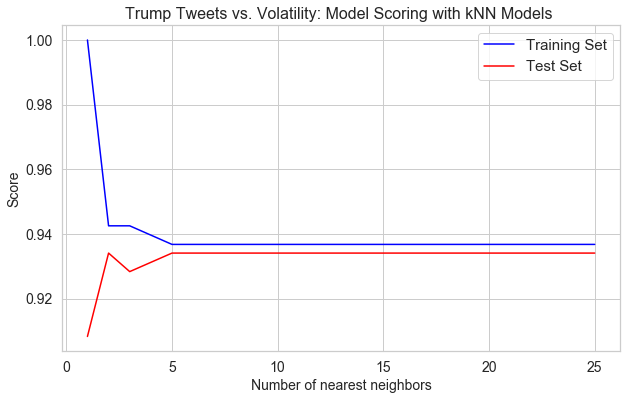

In [42]:
from sklearn.neighbors import KNeighborsClassifier


k_list = [1,2,3,5,6,7,8,10,20,25]
k_cross_scores = []
k_train_scores = []
k_test_scores = []
for k in k_list:
    kNN = KNeighborsClassifier(n_neighbors = k).fit(X_train_scaled,y_train2)

    train_score = kNN.score(X_train_scaled,y_train2)
    cross_score = np.mean(cross_val_score(kNN,X_train_scaled,y_train2,cv=5))
    test_score = kNN.score(X_test_scaled,y_test2)
    k_train_scores.append(train_score)
    k_cross_scores.append(cross_score)
    k_test_scores.append(test_score)
    
    print("The number of neighbors is",k,"The training set_score is ",train_score,". The validation set score is",cross_score,"The test set score is",test_score)
    
    
    
    
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(k_list,k_train_scores, color='blue', label='Training Set')
ax1.plot(k_list,k_test_scores,color='red',  label='Test Set')

ax1.set_xlabel("Number of nearest neighbors",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Model Scoring with kNN Models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()
    

### Decision Tree Model Classifier

The max depth is 1 The training set_score is  0.9396551724137931 . The validation set score is 0.9311731257107864 The test set score is 0.9255014326647565
The max depth is 2 The training set_score is  0.9396551724137931 . The validation set score is 0.9282331671186539 The test set score is 0.9255014326647565
The max depth is 3 The training set_score is  0.9396551724137931 . The validation set score is 0.9137404134954655 The test set score is 0.9255014326647565
The max depth is 4 The training set_score is  0.9482758620689655 . The validation set score is 0.9051264106377396 The test set score is 0.9140401146131805
The max depth is 5 The training set_score is  0.9597701149425287 . The validation set score is 0.8849193713002654 The test set score is 0.9197707736389685
The max depth is 10 The training set_score is  0.9971264367816092 . The validation set score is 0.8505059341556584 The test set score is 0.8796561604584527
The max depth is 20 The training set_score is  1.0 . The validation s

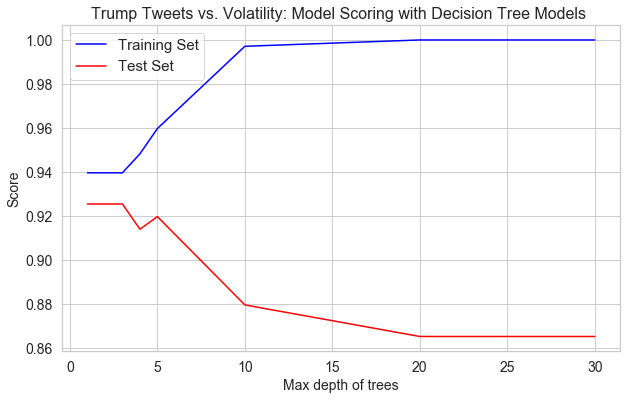

In [43]:
from sklearn.tree import DecisionTreeClassifier


max_depth = [1,2,3,4,5,10,20,30]
tree_models = []
tree_train_score = []
tree_cross_score = []
tree_test_score = []
for depth in max_depth:
    
    dtree = DecisionTreeClassifier(max_depth=depth)
    dtree.fit(X_train_scaled,y_train2)
    train_score = dtree.score(X_train_scaled,y_train2)
    test_score = dtree.score(X_test_scaled,y_test2)
    cross_score = np.mean(cross_val_score(dtree,X_train_scaled,y_train2,cv=5))
    tree_models.append(dtree)
    tree_train_score.append(train_score)
    tree_cross_score.append(cross_score)
    tree_test_score.append(test_score)
    print("The max depth is",depth,"The training set_score is ",train_score,". The validation set score is",cross_score,"The test set score is",test_score)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(max_depth,tree_train_score, color='blue', label='Training Set')
ax1.plot(max_depth,tree_test_score,color='red',  label='Test Set')

ax1.set_xlabel("Max depth of trees",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Model Scoring with Decision Tree Models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()



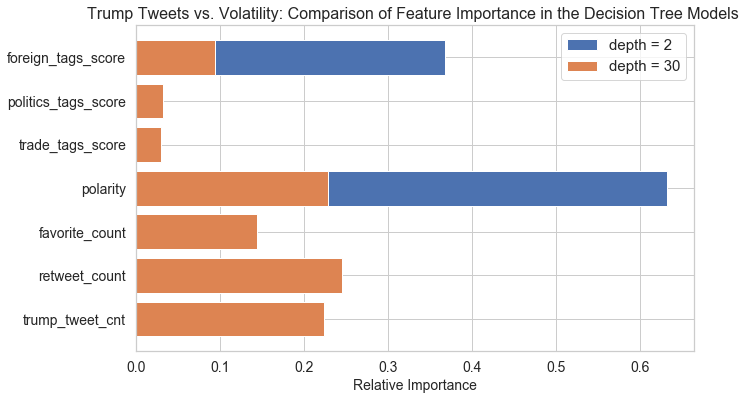

In [44]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.barh(X_train.columns,tree_models[1].feature_importances_,label='depth = 2')

ax1.barh(X_train.columns,tree_models[-1].feature_importances_,label='depth = 30')
ax1.legend(fontsize=15)
ax1.set_xlabel("Relative Importance",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Comparison of Feature Importance in the Decision Tree Models ', fontsize=16)
plt.show()

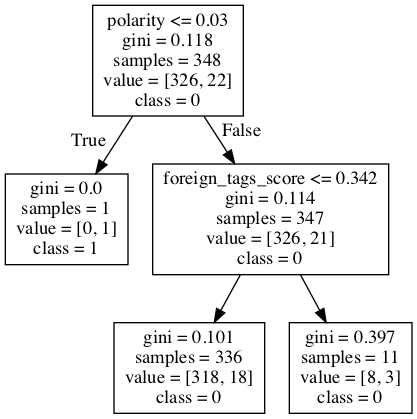

In [45]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
dot_data = export_graphviz(tree_models[1],out_file=None,max_depth=2,feature_names = list(X_train.columns),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

### ANN Model

In [46]:
input_dimension = X_train_scaled.shape[1]
output_dimension = 1
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10,input_dim = input_dimension,kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(50,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(10,activation = 'relu',kernel_initializer = 'normal'),

    tf.keras.layers.Dense(output_dimension,activation = 'sigmoid'),

])

model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train2,validation_split=0.2,epochs=100,batch_size=50)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_7 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_8 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_9 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_10 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 11        
Total params: 2,591
Trainable params: 2,591
Non-trainable params: 0
____________________________________________________

278/278 [==============================] - 0s 41us/sample - loss: 0.3716 - accuracy: 0.9388 - val_loss: 0.3881 - val_accuracy: 0.9286
Epoch 48/100
278/278 [==============================] - 0s 40us/sample - loss: 0.3161 - accuracy: 0.9388 - val_loss: 0.3427 - val_accuracy: 0.9286
Epoch 49/100
278/278 [==============================] - 0s 41us/sample - loss: 0.3416 - accuracy: 0.9388 - val_loss: 0.3671 - val_accuracy: 0.9286
Epoch 50/100
278/278 [==============================] - 0s 44us/sample - loss: 0.3223 - accuracy: 0.9388 - val_loss: 0.3378 - val_accuracy: 0.9286
Epoch 51/100
278/278 [==============================] - 0s 42us/sample - loss: 0.3077 - accuracy: 0.9388 - val_loss: 0.3519 - val_accuracy: 0.9286
Epoch 52/100
278/278 [==============================] - 0s 42us/sample - loss: 0.3066 - accuracy: 0.9388 - val_loss: 0.3330 - val_accuracy: 0.9286
Epoch 53/100
278/278 [==============================] - 0s 48us/sample - loss: 0.2966 - accuracy: 0.9388 - val_loss: 0.3282 - val_a

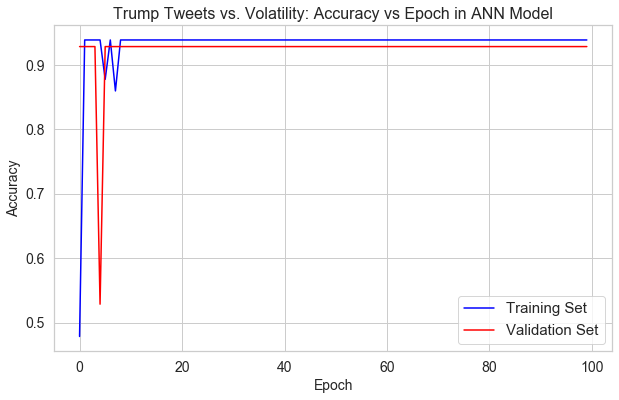

In [47]:


fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(np.array(history.history['accuracy']), color='blue', label='Training Set')
ax1.plot(np.array(history.history['val_accuracy']),color ='red',  label='Validation Set')

ax1.set_xlabel("Epoch",fontsize=14)
ax1.set_ylabel("Accuracy",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Accuracy vs Epoch in ANN Model', fontsize=16)
plt.legend(fontsize = 15)
plt.show()

0.9340974212034384


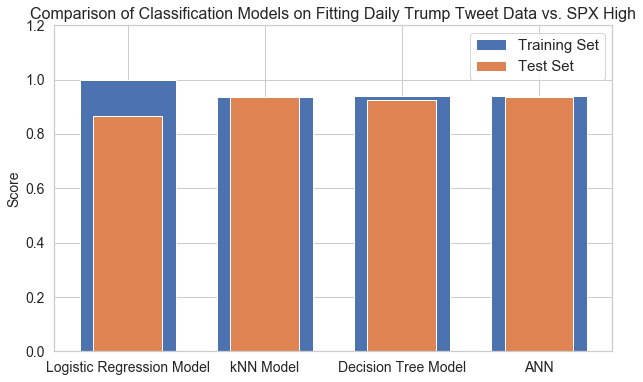

In [48]:
print(accuracy_score(y_test2,np.rint(model.predict(X_test_scaled))))

fig,ax = plt.subplots(1,1,figsize=(10,6))

ax.bar(['Logistic Regression Model','kNN Model','Decision Tree Model','ANN'],[train_score,k_train_scores[3],tree_train_score[1],np.array(history.history['accuracy'])[-1]],label='Training Set',width=0.7)
ax.bar(['Logistic Regression Model','kNN Model','Decision Tree Model','ANN'],[test_score,k_test_scores[3],tree_test_score[1],accuracy_score(y_test2,np.rint(model.predict(X_test_scaled)))],label='Test Set',width=0.5)
ax.legend(fontsize=15)
ax.set_ylabel("Score",fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylim(0,1.2)
ax.set_title('Comparison of Classification Models on Fitting Daily Trump Tweet Data vs. SPX High',fontsize=16)
plt.show()

## The high fitting scores from the above models result from the small number of positive response in the y

Out of 697 days of data, only 45 days have volatile market data, which is 6.45%. That is to say, even if the model always outputs 0 regardless of the input, the accuracy rate would still be 93.55%. To solve this issue, we try to add duplicate data of the volatile=1 case, and make volatile=1 data percentage approximately 50%.

In [49]:
print(sum(df_cbm.Volatile))
print(len(df_cbm))

45
697


## Adding Duplicate Data to Include More Volatile data

In [67]:


x = df_cbm[['trump_tweet_cnt','retweet_count','favorite_count','polarity','trade_tags_score','politics_tags_score','foreign_tags_score']]

y = df_cbm['Volatile']


X_train,X_test,y_train2,y_test2 = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)


new_training = X_train
new_training['Volatile'] = y_train2


volatile_df = new_training[new_training['Volatile']==1]

new_training = new_training.append([volatile_df]*22,ignore_index=True)
display(new_training.describe())

y_train2 = new_training.Volatile
X_train = new_training.drop(['Volatile'],axis=1)




# fit the scaler on the X_train
scaler = preprocessing.MinMaxScaler().fit(X_train)

# Scale X_train and X_test
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Making the numpy scaled matrices pandas dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


logistic_model = LogisticRegression(C=1000000)
logistic_model.fit(X_train_scaled,y_train2)

log_train_score = logistic_model.score(X_train_scaled,y_train2)
log_test_score = logistic_model.score(X_test_scaled,y_test2)
print("Training set score after normalization",logistic_model.score(X_train_scaled,y_train2))
print("Test set score after normalization",logistic_model.score(X_test_scaled,y_test2))




/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


trump_tweet_cnt  retweet_count  favorite_count     polarity  trade_tags_score  politics_tags_score  foreign_tags_score     Volatile
count      1349.000000    1349.000000    1.349000e+03  1349.000000       1349.000000          1349.000000         1349.000000  1349.000000
mean         10.218681  241954.732394    8.974100e+05     6.798517          5.604893             1.417346            1.521127     0.613788
std           5.872817  143561.659635    4.829456e+05    10.911011         12.451223             1.624651            2.503506     0.487061
min           0.000000       0.000000    0.000000e+00   -25.000000          0.000000             0.000000            0.000000     0.000000
25%           6.000000  129262.000000    5.017140e+05     0.000000          0.000000             0.000000            0.000000     0.000000
50%           9.000000  212267.000000    8.397640e+05     6.200000          0.000000             1.000000            1.000000     1.000000
75%          14.000000  339040.000000    1.221003e+06    12.700000          6.000000             2.000000            2.000000     1.000000
max          36.000000  789785.000000    2.639593e+06    59.600000        119.000000            11.000000           19.000000     1.000000

Training set score after normalization 0.6041512231282431
Test set score after normalization 0.3357142857142857


/Users/shijianjin/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### kNN classifier on augmented dataset

The number of neighbors is 1 The training set_score is  1.0 . The validation set score is 0.9703701468241448 The test set score is 0.8857142857142857
The number of neighbors is 2 The training set_score is  1.0 . The validation set score is 0.9703701468241448 The test set score is 0.8857142857142857
The number of neighbors is 3 The training set_score is  0.9755374351371386 . The validation set score is 0.9444111360568377 The test set score is 0.85
The number of neighbors is 5 The training set_score is  0.9570051890289103 . The validation set score is 0.9169787829228973 The test set score is 0.7714285714285715
The number of neighbors is 6 The training set_score is  0.9570051890289103 . The validation set score is 0.9169787829228973 The test set score is 0.7714285714285715
The number of neighbors is 7 The training set_score is  0.9295774647887324 . The validation set score is 0.9014203720723701 The test set score is 0.7428571428571429
The number of neighbors is 8 The training set_score is

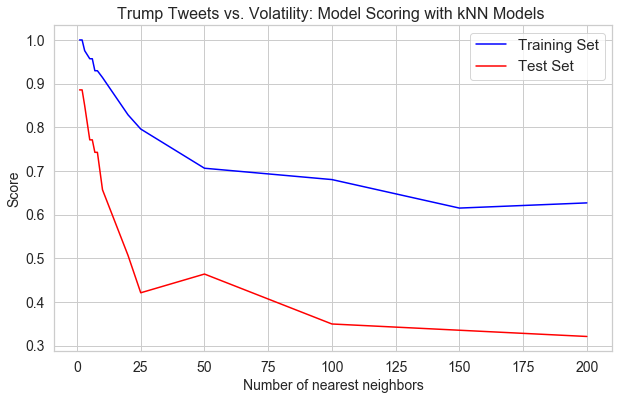

In [68]:
from sklearn.neighbors import KNeighborsClassifier


k_list = [1,2,3,5,6,7,8,10,20,25,50,100,150,200]
k_cross_scores = []
k_train_scores = []
k_test_scores = []
for k in k_list:
    kNN = KNeighborsClassifier(n_neighbors = k).fit(X_train_scaled,y_train2)

    train_score = kNN.score(X_train_scaled,y_train2)
    cross_score = np.mean(cross_val_score(kNN,X_train_scaled,y_train2,cv=5))
    test_score = kNN.score(X_test_scaled,y_test2)
    k_train_scores.append(train_score)
    k_cross_scores.append(cross_score)
    k_test_scores.append(test_score)
    
    print("The number of neighbors is",k,"The training set_score is ",train_score,". The validation set score is",cross_score,"The test set score is",test_score)
    
    
    
    
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(k_list,k_train_scores, color='blue', label='Training Set')
ax1.plot(k_list,k_test_scores,color='red',  label='Test Set')

ax1.set_xlabel("Number of nearest neighbors",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Model Scoring with kNN Models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()
    

### Decision Tree Classifier on the Augmented Dataset

The max depth is 1 The training set_score is  0.6160118606375092 . The validation set score is 0.6108088461305926 The test set score is 0.6714285714285714
The max depth is 2 The training set_score is  0.6767976278724982 . The validation set score is 0.6745761487354651 The test set score is 0.24285714285714285
The max depth is 3 The training set_score is  0.7094143810229799 . The validation set score is 0.6997642908275428 The test set score is 0.3357142857142857
The max depth is 4 The training set_score is  0.7242401779095626 . The validation set score is 0.7190484754909507 The test set score is 0.36428571428571427
The max depth is 5 The training set_score is  0.7501853224610823 . The validation set score is 0.746478095264224 The test set score is 0.4142857142857143
The max depth is 10 The training set_score is  0.9288361749444033 . The validation set score is 0.9281503124820591 The test set score is 0.7142857142857143
The max depth is 20 The training set_score is  1.0 . The validation 

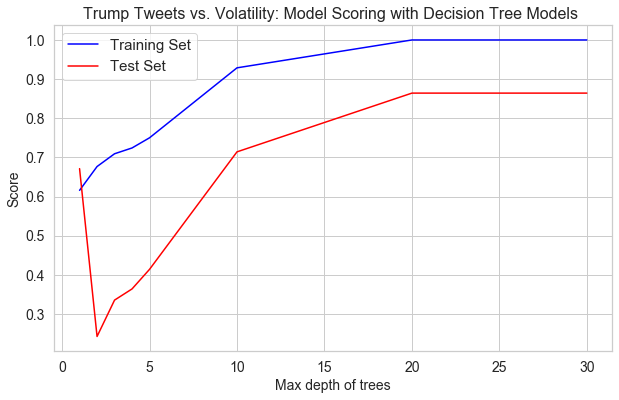

In [52]:
from sklearn.tree import DecisionTreeClassifier


max_depth = [1,2,3,4,5,10,20,30]
tree_models = []
tree_train_score = []
tree_cross_score = []
tree_test_score = []
for depth in max_depth:
    
    dtree = DecisionTreeClassifier(max_depth=depth)
    dtree.fit(X_train_scaled,y_train2)
    train_score = dtree.score(X_train_scaled,y_train2)
    test_score = dtree.score(X_test_scaled,y_test2)
    cross_score = np.mean(cross_val_score(dtree,X_train_scaled,y_train2,cv=5))
    tree_models.append(dtree)
    tree_train_score.append(train_score)
    tree_cross_score.append(cross_score)
    tree_test_score.append(test_score)
    print("The max depth is",depth,"The training set_score is ",train_score,". The validation set score is",cross_score,"The test set score is",test_score)

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(max_depth,tree_train_score, color='blue', label='Training Set')
ax1.plot(max_depth,tree_test_score,color='red',  label='Test Set')

ax1.set_xlabel("Max depth of trees",fontsize=14)
ax1.set_ylabel("Score",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Model Scoring with Decision Tree Models ', fontsize=16)
plt.legend(fontsize = 15)
plt.show()


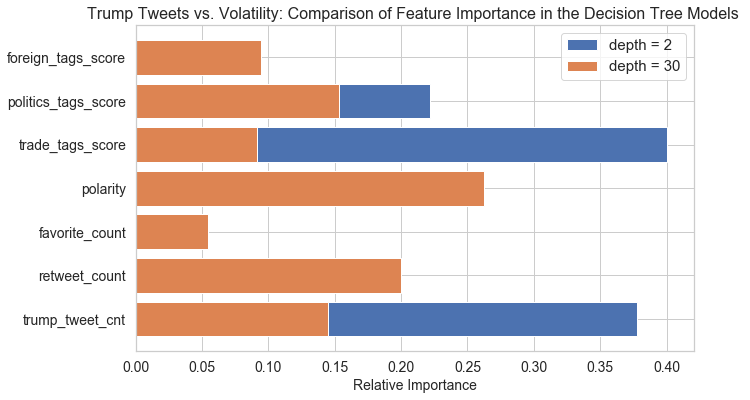

In [53]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.barh(X_train.columns,tree_models[1].feature_importances_,label='depth = 2')

ax1.barh(X_train.columns,tree_models[-1].feature_importances_,label='depth = 30')
ax1.legend(fontsize=15)
ax1.set_xlabel("Relative Importance",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Comparison of Feature Importance in the Decision Tree Models ', fontsize=16)
plt.show()

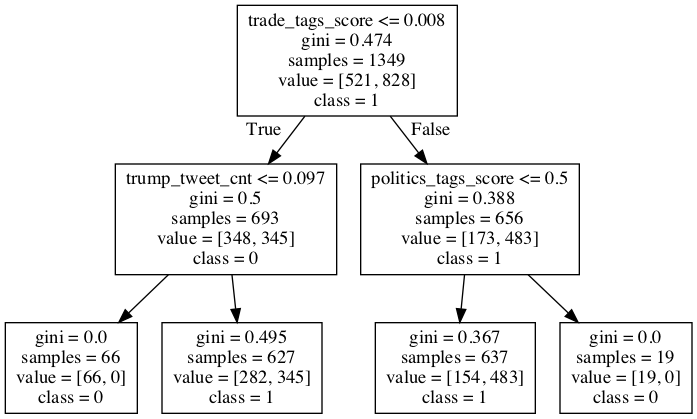

In [54]:
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
dot_data = export_graphviz(tree_models[1],out_file=None,max_depth=2,feature_names = list(X_train.columns),class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [55]:
input_dimension = X_train_scaled.shape[1]
output_dimension = 1
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20,input_dim = input_dimension,kernel_initializer = 'normal'),
    tf.keras.layers.Dense(10,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(25,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(20,activation = 'relu',kernel_initializer = 'normal'),
    tf.keras.layers.Dense(10,activation = 'relu',kernel_initializer = 'normal'),

    tf.keras.layers.Dense(output_dimension,activation = 'sigmoid'),

])

model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

history = model.fit(X_train,y_train2,validation_split=0.2,epochs=100,batch_size=50)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 20)                160       
_________________________________________________________________
dense_13 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_14 (Dense)             (None, 25)                275       
_________________________________________________________________
dense_15 (Dense)             (None, 20)                520       
_________________________________________________________________
dense_16 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 11        
Total params: 1,386
Trainable params: 1,386
Non-trainable params: 0
____________________________________________________

1079/1079 [==============================] - 0s 30us/sample - loss: 0.6829 - accuracy: 0.5533 - val_loss: 0.6193 - val_accuracy: 0.7296
Epoch 47/100
1079/1079 [==============================] - 0s 33us/sample - loss: 0.6816 - accuracy: 0.5533 - val_loss: 0.5898 - val_accuracy: 0.7556
Epoch 48/100
1079/1079 [==============================] - 0s 34us/sample - loss: 0.6807 - accuracy: 0.5468 - val_loss: 0.6853 - val_accuracy: 0.5000
Epoch 49/100
1079/1079 [==============================] - 0s 33us/sample - loss: 0.6831 - accuracy: 0.5468 - val_loss: 0.6438 - val_accuracy: 0.6407
Epoch 50/100
1079/1079 [==============================] - 0s 33us/sample - loss: 0.6809 - accuracy: 0.5477 - val_loss: 0.6283 - val_accuracy: 0.7000
Epoch 51/100
1079/1079 [==============================] - 0s 34us/sample - loss: 0.6836 - accuracy: 0.5672 - val_loss: 0.6292 - val_accuracy: 0.7000
Epoch 52/100
1079/1079 [==============================] - 0s 33us/sample - loss: 0.6814 - accuracy: 0.5579 - val_loss: 

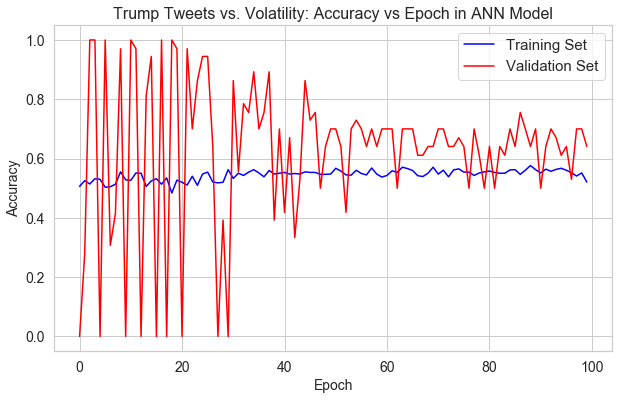

In [56]:
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(np.array(history.history['accuracy']), color='blue', label='Training Set')
ax1.plot(np.array(history.history['val_accuracy']),color ='red',  label='Validation Set')

ax1.set_xlabel("Epoch",fontsize=14)
ax1.set_ylabel("Accuracy",fontsize=14)
ax1.tick_params(axis='both', labelsize=14)
plt.title('Trump Tweets vs. Volatility: Accuracy vs Epoch in ANN Model', fontsize=16)
plt.legend(fontsize = 15)
plt.show()

0.9357142857142857


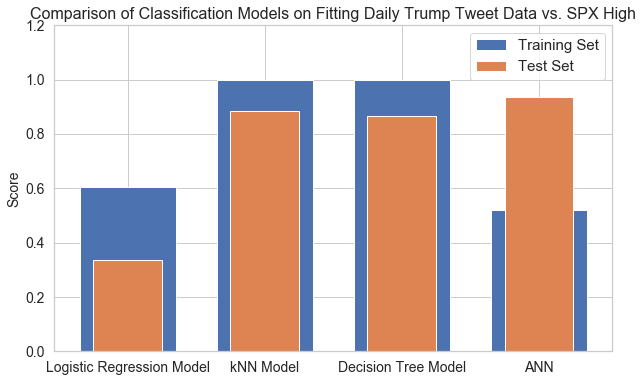

In [57]:
print(accuracy_score(y_test2,np.rint(model.predict(X_test_scaled))))

fig,ax = plt.subplots(1,1,figsize=(10,6))

ax.bar(['Logistic Regression Model','kNN Model','Decision Tree Model','ANN'],[log_train_score,k_train_scores[1],tree_train_score[6],np.array(history.history['accuracy'])[-1]],label='Training Set',width=0.7)
ax.bar(['Logistic Regression Model','kNN Model','Decision Tree Model','ANN'],[log_test_score,k_test_scores[1],tree_test_score[6],accuracy_score(y_test2,np.rint(model.predict(X_test_scaled)))],label='Test Set',width=0.5)
ax.legend(fontsize=15)
ax.set_ylabel("Score",fontsize=14)
ax.tick_params(axis='both', labelsize=14)
ax.set_ylim(0,1.2)
ax.set_title('Comparison of Classification Models on Fitting Daily Trump Tweet Data vs. SPX High',fontsize=16)
plt.show()

# Future Work

### Milestone 3

1. The baseline model clearly gives terrible fitting. The failure is due to the lack of proper predictors. The number of tweets by Trump does not mean much to the market; rather, it's the content in those tweets that matters more. A simple modification on the current dataset is to have a column named ave_retweet or ave_favorite, whose value is `retweet_count`/`trump_tweet_cnt` or `favorite_count`/`trump_tweet_cnt`. This column would reflect the importance of the tweets at a particular day. We expect important tweets have more influence on the market.

2. An important task to do is to categorize the tweets based on the content. Possible categories are, whether a tweet mentions market(e.g. mentions a company's name or an industry), whether a tweet mentions trade war, whether a tweet expresses positive or negative attitude, whether a tweet uses strong language or not. After categorization, we may use models such as decision tree to find out the most important features that influence the market.

3. We will find out the most frequent phrases that Trump uses in the tweets and check how the appearance of these phrases influence market behavior.

4. We can include more features into the market data. For example, we can have a column named big_change, indicating whether the stock/index experiences a change that is way larger than $2*std$. 

# Conclusion and Future Work

1. After milestone3, we implemented several methods to incorporate the contents of Trump's tweets into our model.
    a. We identified the polarity of Trump's tweets by summing the polarity score of each word in a tweet. The word-polarity score was modeled using Vader-Sentiment model, which was an open source model specifically made for modeling the sentiment people express on social media.
    b. We made three tags, i.e. trade, foreign and politics, that categorize Trump's tweets content. Each tag has a tag score, and the tag score increases whenever a word related with the tag is mentioned. For example, when the word 'trade' is mentioned, trade tag score increases by 1.
   
   In total we added four features, `polarity`,`trade_tag_score`,`foreign_tag_score` and `politics_tag_score` to the dataset that relate to the content of Trump's tweets.


2. We were still interested in whether Trump's tweets directly impact the price of the stock market. So we fitted the newly constructed feature set to the response variable `High` , which gives the high price point of daily SPX500, just like what we did in milestone3. We used simple linear regression, kNN models, decision tree models and ANN but none of them give high fitting score. After normalization of the feature set, the score even became negative. Therefore, we concluded, the current features in the dataset, even though some features did reflect on the content or mood of Trump, were not correlated with the price of SPX500, at all. We hypothesized Trump's tweets do not influence the market at all, and to test that hypothesis, we would need to include more features and run the fitting.


3. We were also interested in whether Trump's tweets relate with the volatility of the stock market. We define a `volatile` day to have `percent change` that is two standard deviation away from the mean. Again we used logistic regression (with and without regularization), kNN classifiers, decision tree classifiers and 6-layer ANN to fit the data. Surprisingly, we obtained close to 95% score for training and test across all models. After some thoughts, we found the reason for high score was caused by the lack of positive `volatile` data points. The positive volatile days only account for around 6% of total data. That is to say, if the model only returns 0 regardless of input features, the accuracy would still be 94%.


4. To address the issue of lacking positive data, we tried to augmented our dataset by adding duplicate data of the positive `volatile` data points to the training set. The score of simple logistic regression decreases but other models still return high score on test sets. That was because the test set sill had only ~6% positive `volatile` data and the more complicated models all just return 0 regardless of the inputs. So adding duplicate data is not the best solution.

5. In the future, we would attempt add more tags of different category to the feature set and then perform fitting. Another issue is the lack of volatile days. This may be addressed by using some other index to replace SPX500. For example, use the Chinese market index, which is also considered by a lot of people to be highly relev

# Topic Modeling - Tweets text

## Theoretical Overview

LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words, and each document is a mixture of over a set of topic probabilities.    
    
We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:    
psi -- the distribution of words for each topic K    
phi -- the distribution of topics for each document i    

In [58]:
print('Total tweets', len(df_tweets))
df_tweets.head()

Total tweets 11568


polarity              source                                               text  created_at  retweet_count  favorite_count is_retweet                                            no_punc
id                                                                                                                                                                                                    
8.225021e+17       3.7  Twitter for iPhone  What truly matters is not which party controls...  2017-01-20        42790.0        180394.0      False  What truly matters is not which party controls...
8.225026e+17       3.9  Twitter for iPhone  We will bring back our jobs. We will bring bac...  2017-01-20        37458.0        173821.0      False  We will bring back our jobs  We will bring bac...
8.225029e+17       0.0  Twitter for iPhone  We will follow two simple rules: BUY AMERICAN ...  2017-01-20        38092.0        161358.0      False  We will follow two simple rules  BUY AMERICAN ...
8.225041e+17       0.0  Twitter for iPhone  So to all Americans in every city near and far...  2017-01-20        14039.0         86467.0      False  So to all Americans in every city near and far...
8.226691e+17       2.7  Twitter for iPhone  THANK YOU for another wonderful evening in Was...  2017-01-21        52468.0        289942.0      False  THANK YOU for another wonderful evening in Was...

In [59]:
def grep_ref_tweet_ids(text):
    ref_tweet_ids=[]
    ref_tweet_ids = re.findall(r'@(\w+)\W',text)
    #clean_text= re.sub(r'@(\w+)\W', r' ', text)
    return ref_tweet_ids, clean_text

In [60]:
def grep_hash_tags(text):
    ref_hash_tags=[]
    ref_hash_tags = re.findall(r'#([\w]{3,})\W',text)
    clean_text= text #re.sub(r'#([\w]{3,})\W', r' ', text)
    return ref_hash_tags, clean_text

In [61]:
def grep_ref_https_link(text):
    ref_http_links=[]
    ref_http_links=[]
    ref_http_links = re.findall(r'(https?://[\w\.\/]+)\W',text)
    clean_text=text
    return ref_http_links, clean_text

In [62]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/Users/shijianjin/nltk_data'
    - '/Users/shijianjin/opt/anaconda3/nltk_data'
    - '/Users/shijianjin/opt/anaconda3/share/nltk_data'
    - '/Users/shijianjin/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
# Load the regular expression library
import re

# Remove punctuation
df_tweets['tweet_text_processed'] = df_tweets['text'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the tweets to lowercase
df_tweets['tweet_text_processed'] = df_tweets['tweet_text_processed'].map(lambda x: x.lower())

# Print out the few rows of tweets
df_tweets['tweet_text_processed'].head()

### Exploratory Analysis - WordCloud

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed tweets together
long_string = ','.join(list(df_tweets['tweet_text_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Prepare text for LDA analysis

In [ ]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed tweets
count_data = count_vectorizer.fit_transform(df_tweets['tweet_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

### LDA model tranining

In [ ]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 5
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)